## MSAE training and feature analysis

Main goal: look at different levels of features in a 3-level MSAE

Steps:

1. Train MSAE on spikes dataset

2. Create (topk) sae feature df

3. Create stim (meta)data df

4. Interp / autointerp
    
    a. Create infra for finding stim at times of particular feature(s)
    
    b. Create infra for finding topk SAE features that fire at times of particular stim

In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [ ]:
"""Import packages."""

# Standard library imports
import math
import os
from collections import defaultdict
from dataclasses import dataclass
from datetime import datetime
from functools import partial
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

# IPython and Jupyter-related imports
import ipywidgets as widgets
from IPython.display import clear_output, display

# Third-party libraries
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import temporaldata as td
import torch as t
from einops import (
    asnumpy,
    einsum,
    pack,
    parse_shape,
    rearrange,
    reduce,
    repeat,
    unpack,
)
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from scipy import stats
from scipy.ndimage import uniform_filter1d
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from temporaldata import Data
from torch import Tensor, bfloat16, nn
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

# Local project modules
from mini import train as mt
from mini.util import vec_r2

In [3]:
# Set max rows and cols for df display
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 25)

In [4]:
def clean_session_data(session):
    """Clean session data by filtering trials and spikes based on quality criteria."""
    
    # Mark Churchland gave me a matlab script which I have converted to python

    num_trials = len(session.trials.start)
    # I think is_valid is already defined by brainsets as (session.trials.discard_trial == 0) & (session.trials.task_success == 1) so it's a bit redundant but including it all just to be sure
    # In theory I should also filter based on whether the maze was possible or not (a field called "unhittable") but I cannot find this in the data, perhaps this has already been done in this release of the data
    good_trials = (session.trials.trial_type > 0) & (session.trials.is_valid == 1) & (session.trials.discard_trial == 0) &(session.trials.novel_maze == 0) & (session.trials.trial_version < 3) 
    session.trials = session.trials.select_by_mask(good_trials)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out extraneous trials, went from", num_trials, "trials to", new_num_trials)

    num_trials = len(session.trials.start)
    success = (session.trials.task_success == 1)
    session.trials = session.trials.select_by_mask(success)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out unsuccessful trials, went from", num_trials, "trials to", new_num_trials)

    num_trials = len(session.trials.start)
    post_move = 0.8 # to be kept, there must be at least this many ms after the movement onset
    long_enough = (session.trials.end - session.trials.move_begins_time >= post_move) # should essentially always be true for successes
    session.trials = session.trials.select_by_mask(long_enough)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out trials that were too short, went from", num_trials, "trials to", new_num_trials)

    num_trials = len(session.trials.start)
    consistent = (session.trials.correct_reach == 1)
    session.trials = session.trials.select_by_mask(consistent)
    new_num_trials = len(session.trials.start)
    if num_trials - new_num_trials > 0:
        print("Filtered out trials with inconsistent reaches (not similar enough to the \"prototypical\" trial), went from", num_trials, "trials to", new_num_trials)

    primary_conditions = np.unique(session.trials.maze_condition)
    num_conditions = len(primary_conditions)
    print("Number of primary conditions:", num_conditions)
    # Check to make sure they are monotonic, starting from 1 and counting up
    if min(primary_conditions) != 1 or len(np.unique(np.diff(primary_conditions))) != 1:
        raise ValueError("Primary conditions are not monotonic or do not start from 1")

    # In theory I should filter units based on a ranking from 1-4 but I cannot find the ranking in the data, perhaps this has already been done in this release of the data

    # Only keep spikes that are within the cleaned trials
    session.spikes = session.spikes.select_by_interval(session.trials)
    session.hand = session.hand.select_by_interval(session.trials)
    session.eye = session.eye.select_by_interval(session.trials)

    # Convert session recording date to timestamp
    session.session.recording_date = datetime.strptime(session.session.recording_date, '%Y-%m-%d %H:%M:%S')
    session.session.recording_date = session.session.recording_date.timestamp()
    
    return session

In [5]:
def analyze_maze_conditions(session):
    """
    Analyze what each maze_condition corresponds to in terms of 
    maze parameters (barriers, targets, hit positions).
    """
    
    # Get unique maze conditions
    unique_conditions = np.unique(session.trials.maze_condition)
    
    # Create a summary for each condition
    condition_summary = []
    
    for condition in unique_conditions:
        # Get trials for this condition
        condition_mask = session.trials.maze_condition == condition
        
        # Get the unique values for this condition
        barriers = np.unique(session.trials.maze_num_barriers[condition_mask])
        targets = np.unique(session.trials.maze_num_targets[condition_mask])
        hit_positions = np.unique(session.trials.hit_target_position[condition_mask])
        
        # Count trials for this condition
        num_trials = np.sum(condition_mask)
        
        # Store for summary table
        condition_summary.append({
            'Maze Condition': condition,
            'Trials': num_trials,
            'Barriers': ', '.join(map(str, barriers)),
            'Targets': ', '.join(map(str, targets)),
            'Hit Positions': ', '.join(map(str, hit_positions))
        })
    
    summary_df = pd.DataFrame(condition_summary)
    return summary_df

In [6]:
# Path to your data directory
data_path = r"C:\Users\pouge\Documents\mini_data\brainsets\processed\churchland_shenoy_neural_2012"
# data_path = "/ceph/aeon/aeon/SANe/brainsets_data/processed/churchland_shenoy_neural_2012"
data_path = Path(data_path)

# List all h5 files in the directory
h5_files = [f for f in os.listdir(data_path) if f.endswith('.h5')]
print(f"Available h5 files: {h5_files}")

# User parameters
subject_name = "jenkins"  # Change to "nitschke" or "jenkins"
num_files_to_load = 1     # Change to desired number of files

# Filter files by subject
subject_files = [f for f in h5_files if subject_name.lower() in f.lower()]
print(f"\nFiles for subject {subject_name}: {subject_files}")

if len(subject_files) == 0:
    print(f"No files found for subject {subject_name}")
elif len(subject_files) < num_files_to_load:
    print(f"Only {len(subject_files)} files available for {subject_name}, loading all of them")
    num_files_to_load = len(subject_files)

# Load and clean the specified number of files
sessions = []
for i in range(min(num_files_to_load, len(subject_files))):
    file_path = os.path.join(data_path, subject_files[i])
    print(f"\nLoading file {i+1}/{num_files_to_load}: {subject_files[i]}")
    
    # Read neural data from HDF5
    with h5py.File(file_path, "r") as f:
        session = Data.from_hdf5(f)

        session.spikes.materialize()
        session.trials.materialize()
        session.hand.materialize()
        session.eye.materialize()
        session.session.materialize()

        print("Session ID: ", session.session.id)
        print("Session subject id: ", session.subject.id)
        print("Session subject sex: ", session.subject.sex)
        print("Session subject species: ", session.subject.species)
        print("Session recording date: ", session.session.recording_date)
        print("Original number of trials:", len(session.trials.start))
        
        # Clean the session data
        session = clean_session_data(session)
        print("Final number of trials after cleaning:", len(session.trials.start))

        print("Summary of primary conditions:")
        primary_conditions_summary = analyze_maze_conditions(session)
        display(primary_conditions_summary)
        
        sessions.append(session)

print(f"\nSuccessfully loaded and cleaned {len(sessions)} sessions for subject {subject_name}")

Available h5 files: ['jenkins_20090912_center_out_reaching.h5', 'jenkins_20090916_center_out_reaching.h5', 'jenkins_20090918_center_out_reaching.h5', 'jenkins_20090923_center_out_reaching.h5', 'nitschke_20090812_center_out_reaching.h5', 'nitschke_20090819_center_out_reaching.h5', 'nitschke_20090910_center_out_reaching.h5', 'nitschke_20090920_center_out_reaching.h5', 'nitschke_20090922_center_out_reaching.h5', 'nitschke_20100923_center_out_reaching.h5']

Files for subject jenkins: ['jenkins_20090912_center_out_reaching.h5', 'jenkins_20090916_center_out_reaching.h5', 'jenkins_20090918_center_out_reaching.h5', 'jenkins_20090923_center_out_reaching.h5']

Loading file 1/1: jenkins_20090912_center_out_reaching.h5
Session ID:  jenkins_20090912_center_out_reaching
Session subject id:  jenkins
Session subject sex:  MALE
Session subject species:  MACACA_MULATTA
Session recording date:  2009-09-12 00:00:00
Original number of trials: 1588
Filtered out extraneous trials, went from 1588 trials to 13

,Maze Condition,Trials,Barriers,Targets,Hit Positions
0,1,37,0,1,"85, 111"
1,2,39,6,1,"85, 111"
2,3,30,6,3,"85, 111"
3,4,44,0,1,"-80, 133"
4,5,48,6,1,"-80, 133"
5,6,36,6,3,"-80, 133"
6,7,43,0,1,"-116, -5"
7,8,35,6,1,"-116, -5"
8,9,34,6,3,"-116, -5"
9,10,32,0,1,"46, 132"



Successfully loaded and cleaned 1 sessions for subject jenkins


In [7]:
# Parameters
bin_size = 0.05

# Check unit consistency across sessions
unit_ids = np.unique(sessions[0].spikes.unit_index)
for session in sessions:
    unique_units = np.unique(session.spikes.unit_index)
    if not np.array_equal(unique_units, unit_ids):
        raise ValueError("Sessions do not have the same unit IDs. Cannot combine spike data.")

# Determine global bin alignment start point
global_start = min(session.session.recording_date + session.trials.start.min() for session in sessions)
global_start = np.floor(global_start / bin_size) * bin_size  # ensure clean bin alignment

# Collect absolute trial windows across sessions
trial_windows = []
for session in sessions:
    trial_starts = session.trials.start + session.session.recording_date
    trial_ends = session.trials.end + session.session.recording_date
    trial_windows.extend(zip(trial_starts, trial_ends))

trial_windows = np.array(trial_windows)

# Define consistent bin indices across all trial intervals
all_trial_bins = []
for t0, t1 in trial_windows:
    b0 = int(np.floor((t0 - global_start) / bin_size))
    b1 = int(np.ceil((t1 - global_start) / bin_size))
    all_trial_bins.extend(range(b0, b1))

all_trial_bins = np.unique(all_trial_bins)  # remove duplicates and sort

# Convert to consistent timestamps
n_decimals = int(-np.log10(bin_size)) + 1 if bin_size < 1 else 0
consistent_timestamps = np.round(global_start + all_trial_bins * bin_size, n_decimals)

# Accumulator for all binned trials
binned_dfs = []

# Loop over sessions
for session in sessions:
    # Shift spike timestamps to absolute time
    abs_timestamps = session.spikes.timestamps + session.session.recording_date
    unit_ids_this_session = session.spikes.unit_index
    df_spikes = pd.DataFrame({
        'timestamp': abs_timestamps,
        'unit': unit_ids_this_session
    }).sort_values('timestamp')

    # Convert trial times to absolute time
    trial_starts = session.trials.start + session.session.recording_date
    trial_ends = session.trials.end + session.session.recording_date
    df_trials = pd.DataFrame({
        'trial_start': trial_starts,
        'trial_end': trial_ends
    }).sort_values('trial_start')

    # Assign each spike to the most recent trial_start <= timestamp
    df_merged = pd.merge_asof(
        df_spikes,
        df_trials[['trial_start', 'trial_end']],
        left_on='timestamp',
        right_on='trial_start',
        direction='backward'
    )

    # Drop spikes that fall outside their trial interval
    df_merged = df_merged[df_merged['timestamp'] < df_merged['trial_end']]

    # Compute bin index relative to global bin start
    df_merged['bin'] = ((df_merged['timestamp'] - global_start) / bin_size).astype(int)

    # Group by (bin, unit) and count spikes
    df_counts = (
        df_merged
        .groupby(['bin', 'unit'], observed=True)
        .size()
        .reset_index(name='count')
    )

    # Pivot to wide format: units as columns
    spk_cts = df_counts.pivot_table(
        index='bin',
        columns='unit',
        values='count',
        fill_value=0
    )

    # Use consistent trial bins (includes bins with 0 spikes)
    spk_cts = spk_cts.reindex(all_trial_bins, fill_value=0)

    # Convert to consistent timestamps
    spk_cts.index = pd.Index(consistent_timestamps, name='timestamp')
    spk_cts.columns.name = None

    # Collect results
    binned_dfs.append(spk_cts)

# Concatenate all binned trials across sessions
spk_cts_df = pd.concat(binned_dfs)
spk_cts_df = spk_cts_df[~spk_cts_df.index.duplicated()]
spk_cts_df.sort_index(inplace=True)

# Result: each row = time bin, each col = unit, values = spike count
display(spk_cts_df)

,0,1,2,3,4,5,6,7,8,9,10,11,...,179,180,181,182,183,184,185,186,187,188,189,190
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
1.252739e+09,0,1,5,2,3,0,3,2,3,2,5,5,...,1,4,3,1,0,5,2,2,2,1,3,0
1.252739e+09,0,0,2,0,3,0,1,1,3,3,2,6,...,3,0,0,1,1,0,4,3,1,3,3,1
1.252739e+09,1,0,1,0,1,0,0,0,3,3,3,4,...,2,2,2,0,0,0,0,1,2,0,0,3
1.252739e+09,0,2,2,0,3,0,2,0,2,2,6,2,...,1,1,1,1,2,0,0,2,1,1,3,0
1.252739e+09,0,0,1,0,0,1,0,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.252748e+09,0,1,2,3,3,10,5,4,7,2,7,2,...,2,4,2,4,3,3,2,4,5,2,3,5
1.252748e+09,0,4,7,1,4,10,7,6,8,7,8,4,...,5,4,6,5,4,4,4,6,4,5,4,6
1.252748e+09,0,7,3,5,5,11,6,6,6,7,7,6,...,2,1,3,1,1,1,2,3,1,1,3,2


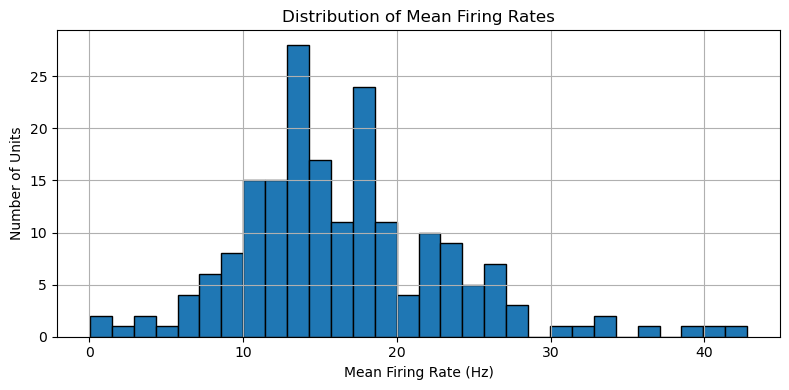

Mean firing rate across units: 16.49 Hz
Median: 15.44 Hz
Range: 0.04–42.78 Hz


In [8]:
# Compute mean firing rate (Hz) per unit
duration_sec = (spk_cts_df.index[-1] - spk_cts_df.index[0]) + bin_size
mean_firing_rates = spk_cts_df.sum(axis=0) / duration_sec  # spikes/sec

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(mean_firing_rates, bins=30, edgecolor='black')
plt.xlabel('Mean Firing Rate (Hz)')
plt.ylabel('Number of Units')
plt.title('Distribution of Mean Firing Rates')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary stats
print("Mean firing rate across units: {:.2f} Hz".format(mean_firing_rates.mean()))
print("Median: {:.2f} Hz".format(np.median(mean_firing_rates)))
print("Range: {:.2f}–{:.2f} Hz".format(mean_firing_rates.min(), mean_firing_rates.max()))


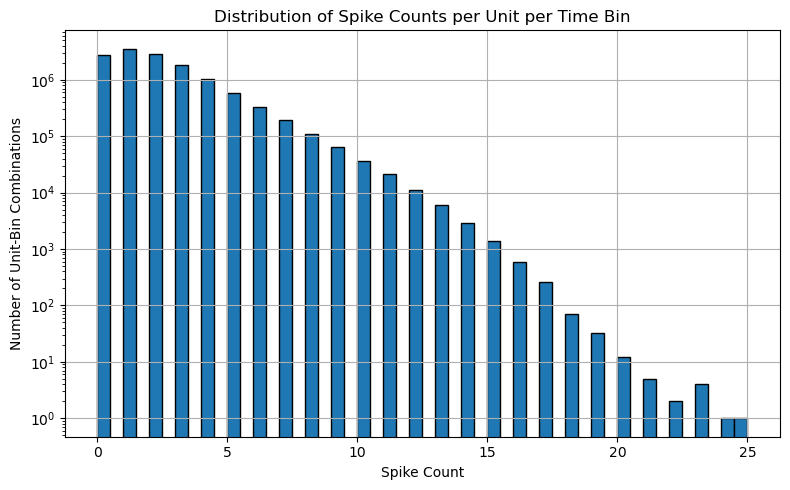

In [9]:
# Flatten the spike count matrix to a 1D array
flattened_spike_counts = spk_cts_df.values.flatten()

# Plot histogram of spike counts
plt.figure(figsize=(8, 5))
plt.hist(flattened_spike_counts, bins=50, edgecolor='black')
plt.title("Distribution of Spike Counts per Unit per Time Bin")
plt.xlabel("Spike Count")
plt.ylabel("Number of Unit-Bin Combinations")
plt.yscale("log")  # Optional: log scale to better visualize skewed distributions
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
"""Check sparsity of binned spike counts."""

frac_nonzero_bins = (spk_cts_df != 0).values.sum() / spk_cts_df.size
frac_nonzero_examples = (spk_cts_df.sum(axis=1) > 0).mean()
print(f"{frac_nonzero_bins=:.4f}")
print(f"{frac_nonzero_examples=:.4f}")

frac_nonzero_bins=0.7957
frac_nonzero_examples=0.9999


In [11]:
"""Load spikes and set sae config."""

# gpu for training
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

spk_cts = t.from_numpy(spk_cts_df.to_numpy()).bfloat16().to(device)
spk_cts /= spk_cts.max()  # max normalize spike counts

dsae_topk_map = {256: 8, 512: 16, 1024: 24}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {256: 1, 512: 1.25, 1024: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
# dsae_topk_map = {1024: 12, 2048: 24, 4096: 48}
dsae = max(dsae_topk_map.keys())
n_inst = 2

display(spk_cts)

device=device(type='cuda')


tensor([[0.0000, 0.0400, 0.2002,  ..., 0.0400, 0.1201, 0.0000],
        [0.0000, 0.0000, 0.0801,  ..., 0.1201, 0.1201, 0.0400],
        [0.0400, 0.0000, 0.0400,  ..., 0.0000, 0.0000, 0.1201],
        ...,
        [0.0000, 0.2793, 0.1201,  ..., 0.0400, 0.1201, 0.0801],
        [0.0000, 0.1201, 0.2793,  ..., 0.0400, 0.0000, 0.0000],
        [0.0000, 0.0801, 0.0000,  ..., 0.0000, 0.0000, 0.0400]],
       device='cuda:0', dtype=torch.bfloat16)

## Train MSAE

In [ ]:

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

## Validate SAEs

In [ ]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

In [ ]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

In [ ]:
"""Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

In [ ]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

In [ ]:
# If cosine similarity is high but r2 is low, it suggests that the model is capturing the structure of the data but not the magnitude.
# Calculate scale ratio of norms to check this

# Expand spk_cts to shape [n_examples, 1, n_units]
spk_cts_exp = spk_cts[:recon_spk_cts.shape[0]].unsqueeze(1)

# Compute norms
true_norms = t.norm(spk_cts_exp, dim=-1)               # shape: [n_examples, 1]
recon_norms = t.norm(recon_spk_cts, dim=-1)            # shape: [n_examples, n_instances]

# Compute scale ratio per example and instance
scale = true_norms / recon_norms                       # shape: [n_examples, n_instances]

print(scale.mean(dim=0))  # if it’s consistently >1 or <1, your model is biased in magnitude

In [ ]:
spk_cts_trimmed = spk_cts[:recon_spk_cts.shape[0]]
bias = (recon_spk_cts - spk_cts_trimmed.unsqueeze(1)).mean(dim=0)
print(bias.mean(dim=0))  # mean bias per unit, averaged across examples

In [ ]:
true_var = spk_cts_trimmed.var(dim=0).mean()
pred_var = recon_spk_cts.var(dim=0).mean()
print(f"True variance: {true_var.item():.4f}, Pred variance: {pred_var.item():.4f}")

### Remove bad units and retrain.

In [ ]:

# Set threshold for removing units
r2_thresh = 0.1
inst = 0
r2_per_unit = r2_per_unit[:, inst]
keep_mask = r2_per_unit > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

# Remove units and retrain
spk_cts = spk_cts[:, keep_mask]

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

In [ ]:
"""Re-Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")


## Get environment / behavior (meta)data

In [12]:
# Accumulators
all_hand_dfs = []
all_eye_dfs = []
all_trials_dfs = []

for i, session in enumerate(sessions):# Hand data
    timestamps = session.hand.timestamps.copy()
    timestamps = timestamps + session.session.recording_date
    acc = session.hand.acc_2d
    pos = session.hand.pos_2d
    vel = session.hand.vel_2d
    hand_df = pd.DataFrame({
        'timestamp': timestamps,
        'acc_x': acc[:, 0],
        'acc_y': acc[:, 1],
        'pos_x': pos[:, 0],
        'pos_y': pos[:, 1],
        'vel_x': vel[:, 0],
        'vel_y': vel[:, 1],
    })
    hand_df['session'] = i
    all_hand_dfs.append(hand_df)

    # Eye data 
    timestamps = session.eye.timestamps.copy()
    timestamps = timestamps + session.session.recording_date
    pos = session.eye.pos
    eye_df = pd.DataFrame({
        'timestamp': timestamps,
        'pos_x': pos[:, 0],
        'pos_y': pos[:, 1],
    })
    all_eye_dfs.append(eye_df)

    # Trial data — just add session start time since they already start from 0
    start = session.trials.start.copy() + session.session.recording_date
    end = session.trials.end.copy() + session.session.recording_date
    target_on_time = session.trials.target_on_time.copy() + session.session.recording_date
    go_cue_time = session.trials.go_cue_time.copy() + session.session.recording_date
    move_begins_time = session.trials.move_begins_time.copy() + session.session.recording_date
    move_ends_time = session.trials.move_ends_time.copy() + session.session.recording_date

    trials_df = pd.DataFrame({
        'start': start,
        'end': end,
        'target_on_time': target_on_time,
        'go_cue_time': go_cue_time,
        'move_begins_time': move_begins_time,
        'move_ends_time': move_ends_time,
        'hit_target_position': [tuple(pos) for pos in session.trials.hit_target_position.copy()],
        'maze_condition':   session.trials.maze_condition.copy(),
    })
    all_trials_dfs.append(trials_df)

# Concatenate everything
combined_hand_df = pd.concat(all_hand_dfs, ignore_index=True)
combined_hand_df.set_index('timestamp', inplace=True)
combined_eye_df = pd.concat(all_eye_dfs, ignore_index=True)
combined_eye_df.set_index('timestamp', inplace=True)
combined_trials_df = pd.concat(all_trials_dfs, ignore_index=True)

# Create full timestamp index from hand, eye, and event times
all_event_ts = np.concatenate([
    combined_trials_df['target_on_time'].values,
    combined_trials_df['go_cue_time'].values,
    combined_trials_df['move_begins_time'].values,
    combined_trials_df['move_ends_time'].values,
])
all_ts = np.unique(np.concatenate([
    combined_hand_df.index.values,
    combined_eye_df.index.values,
    all_event_ts
]))
all_ts.sort()

# Create master dataframe with unified timestamp index
metadata = pd.DataFrame(index=all_ts)
metadata.index.name = 'timestamp'

# Merge hand and eye data
metadata = metadata.join(combined_hand_df, how='left')
metadata = metadata.join(combined_eye_df, how='left', rsuffix='_eye')

# Add event column
event_map = {
    'target_on_time': 'target_on',
    'go_cue_time': 'go_cue',
    'move_begins_time': 'move_begins',
    'move_ends_time': 'move_ends',
}
event_col = pd.Series(index=metadata.index, dtype="object")
for col, label in event_map.items():
    event_times = combined_trials_df[col].values
    matched_ts = np.isin(metadata.index.values, event_times)
    event_col.loc[matched_ts] = label
metadata['event'] = event_col

# Add trial_idx column based on start/end intervals
trial_idx_series = pd.Series(index=metadata.index, dtype='float')
for idx, trial in combined_trials_df.iterrows():
    mask = (metadata.index >= trial['start']) & (metadata.index <= trial['end'])
    trial_idx_series.loc[mask] = idx
metadata['trial_idx'] = trial_idx_series
metadata['hit_target_position'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['hit_target_position']
)
metadata['maze_condition'] = metadata['trial_idx'].astype('Int64').map(
    combined_trials_df['maze_condition']
)

# Add movement_angle column based on position difference
pos_delta_x = metadata['pos_x'].diff()
pos_delta_y = metadata['pos_y'].diff()
metadata['movement_angle'] = np.degrees(np.arctan2(pos_delta_y, pos_delta_x))

# Calculate speed from the velocity vector
metadata['vel_magnitude'] = np.sqrt(metadata['vel_x']**2 + metadata['vel_y']**2)

# Calculate acceleration magnitude from the acceleration vector
metadata['accel_magnitude'] = np.sqrt(metadata['acc_x']**2 + metadata['acc_y']**2)

# Show result
print("Metadata:")
display(metadata)

Metadata:


,acc_x,acc_y,pos_x,pos_y,vel_x,vel_y,session,pos_x_eye,pos_y_eye,event,trial_idx,hit_target_position,maze_condition,movement_angle,vel_magnitude,accel_magnitude
timestamp,,,,,,,,,,,,,,,,
1.252739e+09,-318.112010,-349.493909,2.684289,-27.751781,2.029887,-21.176818,0,-6.0,12.9,NaN,0.0,"(132, 46)",10,NaN,21.273883,472.589931
1.252739e+09,-402.998304,-558.682011,2.686319,-27.772957,1.711775,-21.526312,0,-6.4,11.0,NaN,0.0,"(132, 46)",10,-84.524687,21.594265,688.863718
1.252739e+09,-430.359657,-769.504367,2.687712,-27.794833,1.223890,-22.294182,0,-7.0,13.1,NaN,0.0,"(132, 46)",10,-86.354729,22.327751,881.672504
1.252739e+09,-395.382562,-689.557801,2.688767,-27.817546,0.851056,-23.065321,0,-7.1,11.1,NaN,0.0,"(132, 46)",10,-87.342739,23.081017,794.869380
1.252739e+09,-416.602764,-522.552280,2.689415,-27.840964,0.433125,-23.673298,0,-7.0,9.5,NaN,0.0,"(132, 46)",10,-88.414993,23.677260,668.295405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.252748e+09,-86.161716,-162.571905,128.438120,11.822008,2.227196,-0.156713,0,178.7,-62.4,NaN,1014.0,"(132, 46)",12,-2.310216,2.232702,183.993112
1.252748e+09,-123.121809,-141.393377,128.440275,11.821787,2.087106,-0.324412,0,179.9,-62.2,NaN,1014.0,"(132, 46)",12,-5.846256,2.112168,187.486178
1.252748e+09,-125.174352,-102.852460,128.442294,11.821359,1.980952,-0.439499,0,180.1,-63.0,NaN,1014.0,"(132, 46)",12,-11.972410,2.029121,162.010021


In [13]:
# Create metadata_binned with consistent timestamps
metadata_binned = pd.DataFrame(index=pd.Index(consistent_timestamps, name='timestamp'))

# Assign each metadata row to a bin index
bin_ids = np.digitize(metadata.index.values, consistent_timestamps) - 1
bin_ids = np.clip(bin_ids, 0, len(consistent_timestamps) - 1)

# Aggregate 'event' field across binned metadata, distributing to consecutive bins
event_assignments = {}
for bin_id, events in metadata['event'].groupby(bin_ids):
    events_list = events.dropna().astype(str).tolist()
    for i, event in enumerate(events_list):
        target_bin = bin_id + i
        if target_bin < len(consistent_timestamps):
            event_assignments[target_bin] = event

event_agg = pd.Series(event_assignments).reindex(range(len(consistent_timestamps)))

# Pull nearest rows for all other metadata columns
metadata_nearest = metadata.reindex(consistent_timestamps, method='nearest')

# Copy all columns from nearest metadata
for col in metadata.columns:
    if col != 'event':
        metadata_binned[col] = metadata_nearest[col].values

# Insert distributed events
metadata_binned['event'] = event_agg.values

# Result: metadata for all trial bins, one row per bin
print("Metadata binned:")
display(metadata_binned)

Metadata binned:


,acc_x,acc_y,pos_x,pos_y,vel_x,vel_y,session,pos_x_eye,pos_y_eye,trial_idx,hit_target_position,maze_condition,movement_angle,vel_magnitude,accel_magnitude,event
timestamp,,,,,,,,,,,,,,,,
1.252739e+09,-318.112010,-349.493909,2.684289,-27.751781,2.029887,-21.176818,0,-6.0,12.9,0.0,"(132, 46)",10,NaN,21.273883,472.589931,NaN
1.252739e+09,-497.464127,-632.636229,2.852594,-28.756098,1.907928,-21.723573,0,-7.1,11.7,0.0,"(132, 46)",10,-84.175049,21.807197,804.797587,NaN
1.252739e+09,376.796978,-127.597097,2.207741,-30.821150,-14.462500,-50.774300,0,-6.0,11.2,0.0,"(132, 46)",10,-106.032733,52.793877,397.815261,NaN
1.252739e+09,-284.046162,-209.016365,1.936817,-32.045630,-0.525935,-5.951463,0,-7.6,11.0,0.0,"(132, 46)",10,-93.717577,5.974656,352.661400,NaN
1.252739e+09,-89.561862,160.722499,1.807268,-32.479916,-8.481216,-7.023836,0,-6.1,12.1,0.0,"(132, 46)",10,-139.387473,11.012053,183.991981,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.252748e+09,-106.042665,-79.275781,128.445968,11.820299,1.730715,-0.609392,0,179.9,-62.8,1014.0,"(132, 46)",12,-19.397399,1.834866,132.399760,NaN
1.252748e+09,-106.042665,-79.275781,128.445968,11.820299,1.730715,-0.609392,0,179.9,-62.8,1014.0,"(132, 46)",12,-19.397399,1.834866,132.399760,NaN
1.252748e+09,-106.042665,-79.275781,128.445968,11.820299,1.730715,-0.609392,0,179.9,-62.8,1014.0,"(132, 46)",12,-19.397399,1.834866,132.399760,NaN


## Interpret features

In [14]:
"""Set vars for saving / loading feature act data!"""

load_acts = True  # if True, will load saved feature activations
save_acts = False
sae_datafile = "sae_0.csv"  # set name of data file to load (or save to)

session_dates = []
for session in sessions:
    session_date = datetime.fromtimestamp(session.session.recording_date)
    session_date = session_date.strftime("%Y%m%d")
    session_dates.append(session_date)
session_dates_str = "_".join(session_dates)
session_dates_str

acts_df_save_path = data_path / f"{subject_name}_{session_dates_str}" / "sae_features" / sae_datafile
acts_df_save_path.parent.mkdir(parents=True, exist_ok=True)

In [15]:
"""Load feature activations data."""

if load_acts:
    acts_df = pd.read_csv(acts_df_save_path)
    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

In [16]:
"""Create dfs of feature activations."""

if not load_acts:

    # Convert tensor to numpy array for easier handling
    acts_array = asnumpy(topk_acts_4d)

    # Create DataFrame with the data
    acts_df = pd.DataFrame({
        "example_idx": acts_array[:, 0],
        "instance_idx": acts_array[:, 1],
        "feature_idx": acts_array[:, 2],
        "activation_value": acts_array[:, 3]
    })

    # Convert appropriate cols to ints
    acts_df["example_idx"] = acts_df["example_idx"].astype(int)
    acts_df["feature_idx"] = acts_df["feature_idx"].astype(int)
    acts_df["instance_idx"] = acts_df["instance_idx"].astype(int)

    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

In [17]:
"""Create df with info per feature."""

# Get a features df from acts df
features_df = acts_df.groupby(["instance_idx", "feature_idx"]).agg(
    activation_mean=("activation_value", "mean"),
    activation_std=("activation_value", "std"),
    activation_count=("activation_value", "count")
).reset_index()
features_df["act_mean_over_std"] = features_df["activation_mean"] / features_df["activation_std"]
features_df["activation_frac"] = features_df["activation_count"] / n_recon_examples
features_df = features_df.drop(columns=["activation_count"])
features_df = features_df.dropna().reset_index(drop=True)

if not load_acts:
    # Keep only features from features_df in acts_df
    acts_df = acts_df[acts_df["feature_idx"].isin(features_df["feature_idx"])].reset_index(drop=True)

if save_acts:
    acts_df.to_csv(acts_df_save_path, index=False)

In [18]:
display(acts_df)
display(features_df)

,example_idx,instance_idx,feature_idx,activation_value
0,0,0,12,0.143555
1,0,0,50,0.092285
2,0,0,60,0.414062
3,0,0,113,0.137695
4,0,0,140,0.605469
...,...,...,...,...
3342315,69631,1,721,0.083984
3342316,69631,1,744,0.100586
3342317,69631,1,831,0.070312
3342318,69631,1,916,0.095703


,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
0,0,3,0.186062,0.107326,1.733613,0.476907
1,0,11,0.140201,0.070128,1.999215,0.335406
2,0,12,0.164103,0.104250,1.574125,0.389103
3,0,23,0.067322,0.001509,44.606967,0.000115
4,0,39,0.066406,0.001381,48.083384,0.000029
5,0,45,0.069922,0.005217,13.402012,0.000287
6,0,48,0.067480,0.002427,27.807358,0.000072
7,0,50,0.135430,0.064053,2.114350,0.396743
8,0,52,0.074609,0.008025,9.297694,0.002944
9,0,60,0.552265,0.269501,2.049216,0.989200


In [ ]:
"""Compare features from ("broad" or "general") and ("specific" or "nested") groups"""

last_feat_idx_general = list(dsae_topk_map.keys())[0]
first_feat_idx_specific = list(dsae_topk_map.keys())[1]

# general
print(features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"].describe())
print()
print(features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"].describe())
print()
# specific
print(features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"].describe())

### Hunt for features

In [21]:
"""Automatically map features to metadata"""

def analyze_discrete_variable(
    acts_df: pd.DataFrame,
    metadata_binned: pd.DataFrame,
    variable: str,
    min_activation_frac: float
) -> List[Dict]:
    """
    Analyzes a discrete variable, calculating activation metrics for features meeting a minimum activation fraction.
    This version is corrected to handle features that are 100% selective for an event.
    """
    results = []
    unique_values = metadata_binned[variable].dropna().unique()

    for value in unique_values:
        try:
            event_idxs = np.where(metadata_binned[variable] == value)[0]
            if len(event_idxs) == 0:
                continue

            event_acts_df = acts_df[acts_df["example_idx"].isin(event_idxs)]
            if len(event_acts_df) == 0:
                continue

            event_features_df = event_acts_df.groupby(["instance_idx", "feature_idx"]).agg(
                activation_count=("activation_value", "count")
            ).reset_index()
            n_event_examples = len(event_idxs)
            event_features_df["activation_frac_event"] = event_features_df["activation_count"] / n_event_examples

            promising_features = event_features_df[event_features_df["activation_frac_event"] >= min_activation_frac]
            if promising_features.empty:
                continue

            non_event_mask = ~acts_df["example_idx"].isin(event_idxs)
            non_event_acts_df = acts_df[non_event_mask].merge(
                promising_features[["instance_idx", "feature_idx"]],
                on=["instance_idx", "feature_idx"], how="inner"
            )

            if not non_event_acts_df.empty:
                non_event_features_df = non_event_acts_df.groupby(["instance_idx", "feature_idx"]).agg(
                    activation_count=("activation_value", "count")
                ).reset_index()
                n_non_event_examples = len(metadata_binned) - n_event_examples
                non_event_features_df["activation_frac_non_event"] = non_event_features_df["activation_count"] / n_non_event_examples
                ratio_df = promising_features.merge(
                    non_event_features_df, on=["instance_idx", "feature_idx"], how="left"
                )
                ratio_df["activation_frac_non_event"] = ratio_df["activation_frac_non_event"].fillna(0.0)
            else:
                ratio_df = promising_features.copy()
                ratio_df["activation_frac_non_event"] = 0.0
            
            ratio_df["activation_ratio"] = ratio_df["activation_frac_event"] / (ratio_df["activation_frac_non_event"] + 1e-9)
            ratio_df["rate_proportion"] = ratio_df["activation_frac_event"] / (ratio_df["activation_frac_event"] + ratio_df["activation_frac_non_event"])

            for _, row in ratio_df.iterrows():
                results.append({
                    'variable': variable, 'variable_type': 'discrete', 'value': value,
                    'instance_idx': row['instance_idx'], 'feature_idx': row['feature_idx'],
                    'activation_ratio': row['activation_ratio'],
                    'activation_frac_during': row['activation_frac_event'],
                    'activation_frac_outside': row['activation_frac_non_event'],
                    'rate_proportion': row['rate_proportion']
                })
        except Exception as e:
            print(f"Could not analyze {variable}={value}: {e}")
            continue
    return results

def analyze_continuous_variable(
    acts_df: pd.DataFrame,
    metadata_binned: pd.DataFrame,
    variable: str,
    n_bins: int,
    min_activation_frac: float
) -> List[Dict]:
    """
    Analyzes a continuous variable by binning it and then using the discrete analysis method.
    """
    print(f"  Binning '{variable}' into {n_bins} bins...")
    binned_col_name = f"{variable}_binned"

    data_to_bin = metadata_binned[variable].dropna()
    if data_to_bin.empty:
        return []

    if variable == 'movement_angle':
        bins = np.linspace(-180, 180, n_bins + 1)
        labels = [f"({bins[i]:.0f}, {bins[i+1]:.0f}]" for i in range(n_bins)]
        metadata_binned[binned_col_name] = pd.cut(data_to_bin, bins=bins, labels=labels, include_lowest=True)
    else:
        metadata_binned[binned_col_name] = pd.qcut(data_to_bin, q=n_bins, labels=None, duplicates='drop')

    results = analyze_discrete_variable(acts_df, metadata_binned, binned_col_name, min_activation_frac)

    for res in results:
        res['variable'] = variable
        res['variable_type'] = 'continuous'

    return results

def map_features_to_metadata(
    acts_df: pd.DataFrame,
    metadata_binned: pd.DataFrame,
    discrete_vars: List[str] = None,
    continuous_vars: List[str] = None,
    exclude_columns: List[str] = None,
    min_activation_frac: float = 0.1,
    n_bins_continuous: int = 10,
    top_n_features: int = 3
) -> pd.DataFrame:  
    """
    Automatically maps SAE features to metadata by finding top N features for each condition.
    Returns a single DataFrame with both discrete and continuous results.
    """
    if discrete_vars is None: discrete_vars = []
    if continuous_vars is None: continuous_vars = []
    if exclude_columns is None: exclude_columns = ['trial_idx', 'session']
    
    all_results = []
    print("🚀 Starting automated feature-to-metadata mapping...")
    
    for variable in metadata_binned.columns:
        if variable in exclude_columns:
            continue
        print(f"\nAnalyzing variable: {variable}")
        
        if variable in discrete_vars:
            print(f"  Treating as: discrete")
            results = analyze_discrete_variable(acts_df, metadata_binned, variable, min_activation_frac)
            all_results.extend(results)
        elif variable in continuous_vars:
            print(f"  Treating as: continuous")
            results = analyze_continuous_variable(acts_df, metadata_binned, variable, n_bins=n_bins_continuous, min_activation_frac=min_activation_frac)
            all_results.extend(results)
        else:
            print(f"  Skipping (not in discrete_vars or continuous_vars list)")
            continue
        print(f"  Found {len(results)} potential associations.")
    
    if not all_results:
        print("\nNo associations found meeting the minimum activation fraction!")
        return pd.DataFrame()  # Return empty DataFrame instead of tuple
    
    results_df = pd.DataFrame(all_results)
    results_df['value'] = results_df['value'].astype(str)
    
    print(f"\nRanking features and selecting top {top_n_features} for each condition...")
    ranked_df = (
        results_df.sort_values('activation_ratio', ascending=False)
        .groupby(['variable', 'value', 'instance_idx'])
        .head(top_n_features)
    )
    
    # Sort the combined results
    sort_order = ['variable_type', 'variable', 'value', 'instance_idx', 'activation_ratio']
    ascending_order = [True, True, True, True, False]
    
    final_df = ranked_df.sort_values(by=sort_order, ascending=ascending_order).reset_index(drop=True)
    
    discrete_count = len(final_df[final_df['variable_type'] == 'discrete'])
    continuous_count = len(final_df[final_df['variable_type'] == 'continuous'])
    
    print(f"\n✅ Found {discrete_count} top discrete associations.")
    print(f"✅ Found {continuous_count} top continuous associations.")
    print(f"✅ Total: {len(final_df)} associations returned in single DataFrame.")
    
    return final_df

discrete_vars = ['event', 'maze_condition', 'hit_target_position']
continuous_vars = ['vel_magnitude', 'accel_magnitude', 'movement_angle']

results = map_features_to_metadata(
    acts_df, metadata_binned,
    discrete_vars=discrete_vars,
    continuous_vars=continuous_vars,
    min_activation_frac=0.5,
    n_bins_continuous=12,
    top_n_features=3
)
display(results)

# # Optional filtering (ratio > 2.0, proportion > 0.5)
# results = results[
#     (results['activation_ratio'] > 2.0) & 
#     (results['rate_proportion'] > 0.5)
# ].reset_index(drop=True)
# display(results)

🚀 Starting automated feature-to-metadata mapping...

Analyzing variable: acc_x
  Skipping (not in discrete_vars or continuous_vars list)

Analyzing variable: acc_y
  Skipping (not in discrete_vars or continuous_vars list)

Analyzing variable: pos_x
  Skipping (not in discrete_vars or continuous_vars list)

Analyzing variable: pos_y
  Skipping (not in discrete_vars or continuous_vars list)

Analyzing variable: vel_x
  Skipping (not in discrete_vars or continuous_vars list)

Analyzing variable: vel_y
  Skipping (not in discrete_vars or continuous_vars list)

Analyzing variable: pos_x_eye
  Skipping (not in discrete_vars or continuous_vars list)

Analyzing variable: pos_y_eye
  Skipping (not in discrete_vars or continuous_vars list)

Analyzing variable: hit_target_position
  Treating as: discrete
  Found 63 potential associations.

Analyzing variable: maze_condition
  Treating as: discrete
  Found 202 potential associations.

Analyzing variable: movement_angle
  Treating as: continuous
  

,variable,variable_type,value,instance_idx,feature_idx,activation_ratio,activation_frac_during,activation_frac_outside,rate_proportion
0,accel_magnitude,continuous,"(0.282, 104.02]",0.0,3.0,1.075003,0.503574,0.468439,0.518073
1,accel_magnitude,continuous,"(0.282, 104.02]",0.0,140.0,0.999737,0.977025,0.977282,0.499934
2,accel_magnitude,continuous,"(0.282, 104.02]",0.0,60.0,0.998661,0.976515,0.977824,0.499665
3,accel_magnitude,continuous,"(0.282, 104.02]",1.0,218.0,0.998361,0.976855,0.978459,0.499590
4,accel_magnitude,continuous,"(0.282, 104.02]",1.0,155.0,0.997457,0.974132,0.976616,0.499363
...,...,...,...,...,...,...,...,...,...
423,maze_condition,discrete,9,0.0,60.0,1.009995,0.987138,0.977370,0.502486
424,maze_condition,discrete,9,0.0,140.0,1.007069,0.983923,0.977017,0.501761
425,maze_condition,discrete,9,1.0,234.0,1.044611,0.890675,0.852638,0.510909
426,maze_condition,discrete,9,1.0,218.0,1.009767,0.987540,0.977988,0.502430


In [ ]:
# Helper function: z-score computation for units based on feature activations
def compute_unit_zscores_vectorized(spk_cts_df, feature_active_indices, return_detailed_stats=False):
    """
    Efficiently compute z-scores for all units based on feature activation indices.
    
    This vectorized implementation replaces the slow loop-based z-score calculation
    that was causing performance bottlenecks in the original code.
    
    Parameters:
    - spk_cts_df: DataFrame with units as columns and time bins as rows
    - feature_active_indices: array of indices where feature is active
    - return_detailed_stats: if True, return detailed statistics for each unit
    
    Returns:
    - unit_zscores: dict mapping unit names to z-score values (or detailed stats if requested)
    - top_unit: unit with highest z-score
    """
    # Ensure indices are within bounds and convert to integers
    feature_active_indices = feature_active_indices[feature_active_indices < len(spk_cts_df)]
    feature_active_indices = feature_active_indices.astype(int)
    
    if len(feature_active_indices) == 0:
        # No active indices, return results based on overall activity
        if return_detailed_stats:
            unit_zscores = {unit: {'zscore': 0, 'baseline_mean': 0, 'active_mean': 0, 
                                 'baseline_std': 0, 'n_active_bins': 0, 'n_baseline_bins': len(spk_cts_df)}
                          for unit in spk_cts_df.columns}
        else:
            unit_zscores = {unit: 0 for unit in spk_cts_df.columns}
        top_unit = spk_cts_df.mean().idxmax()
        return unit_zscores, top_unit
    
    # Create boolean mask for active indices (much faster than np.setdiff1d)
    active_mask = np.zeros(len(spk_cts_df), dtype=bool)
    active_mask[feature_active_indices] = True
    baseline_mask = ~active_mask
    
    # Vectorized computation across all units at once
    active_data = spk_cts_df[active_mask]
    baseline_data = spk_cts_df[baseline_mask]
    
    # Compute statistics for all units simultaneously
    active_means = active_data.mean(axis=0)
    baseline_means = baseline_data.mean(axis=0)
    baseline_stds = baseline_data.std(axis=0)
    
    # Compute z-scores vectorized with proper handling of std=0 case
    zscores = np.where(
        baseline_stds > 0,
        (active_means - baseline_means) / baseline_stds,
        np.where(active_means == baseline_means, 0, np.inf)
    )
    
    # Convert to dictionary format
    if return_detailed_stats:
        unit_zscores = {}
        for i, unit in enumerate(spk_cts_df.columns):
            unit_zscores[unit] = {
                'zscore': zscores[i],
                'baseline_mean': baseline_means.iloc[i],
                'active_mean': active_means.iloc[i],
                'baseline_std': baseline_stds.iloc[i],
                'n_active_bins': len(active_data),
                'n_baseline_bins': len(baseline_data)
            }
    else:
        unit_zscores = dict(zip(spk_cts_df.columns, zscores))
    
    # Find top unit (highest z-score)
    top_unit = spk_cts_df.columns[np.argmax(zscores)]
    
    return unit_zscores, top_unit

In [ ]:
"""Visualisation functions for event-feature associations"""

def create_canonical_timeline(combined_trials_df, maze_conditions=None, hit_target_positions=None):
    """
    Create a canonical timeline based on average event durations from the data
    
    Parameters:
    - combined_trials_df: trial metadata with absolute timestamps
    - maze_conditions: list of maze conditions to include (None for all)
    - hit_target_positions: list of target positions to include (None for all)
    
    Returns:
    - canonical_events: dict with canonical event times
    - filtered_trials: dataframe with filtered trials
    """
    
    # Filter trials based on conditions
    filtered_trials = combined_trials_df.copy()
    
    if maze_conditions is not None:
        filtered_trials = filtered_trials[filtered_trials['maze_condition'].isin(maze_conditions)]
        print(f"Filtered to maze conditions: {maze_conditions}")
    
    if hit_target_positions is not None:
        # Handle the tuple format of hit_target_position
        if len(hit_target_positions) > 0 and not isinstance(hit_target_positions[0], tuple):
            # Convert to tuples if needed
            hit_target_positions = [tuple(pos) if isinstance(pos, (list, np.ndarray)) else pos 
                                  for pos in hit_target_positions]
        filtered_trials = filtered_trials[filtered_trials['hit_target_position'].isin(hit_target_positions)]
        print(f"Filtered to target positions: {hit_target_positions}")
    
    print(f"Using {len(filtered_trials)} trials (from {len(combined_trials_df)} total) to create canonical timeline")
    
    if len(filtered_trials) == 0:
        print("No trials match the filtering criteria!")
        return None, None
    
    # Calculate average durations between consecutive events
    events_sequence = ['start', 'target_on_time', 'go_cue_time', 'move_begins_time', 'move_ends_time', 'end']
    
    # Remove trials with missing events
    for event in events_sequence:
        filtered_trials = filtered_trials[filtered_trials[event].notna()]
    
    if len(filtered_trials) == 0:
        print("No trials have all required events!")
        return None, None
    
    print(f"Computing durations from {len(filtered_trials)} complete trials")
    
    # Calculate durations between consecutive events
    durations = {}
    for i in range(len(events_sequence) - 1):
        event1, event2 = events_sequence[i], events_sequence[i + 1]
        trial_durations = filtered_trials[event2] - filtered_trials[event1]
        avg_duration = trial_durations.mean()
        durations[f"{event1}_to_{event2}"] = avg_duration
        print(f"  {event1} → {event2}: {avg_duration:.3f}s (±{trial_durations.std():.3f})")
    
    # Build canonical timeline starting from 0
    canonical_events = {'start': 0.0}
    current_time = 0.0
    
    for i in range(len(events_sequence) - 1):
        event1, event2 = events_sequence[i], events_sequence[i + 1]
        duration_key = f"{event1}_to_{event2}"
        current_time += durations[duration_key]
        canonical_events[event2] = current_time
    
    print(f"\nCanonical timeline: {canonical_events}")
    print(f"Total canonical duration: {current_time:.3f}s")
    
    return canonical_events, filtered_trials


def warp_trials_to_canonical_timeline(combined_trials_df, acts_df, spk_cts_df, metadata_binned,
                                    instance_idx=0, feature_idx=None, 
                                    maze_conditions=None, hit_target_positions=None):
    """
    Warp filtered trials to a data-driven canonical timeline
    
    Parameters:
    - combined_trials_df: trial metadata with absolute timestamps
    - acts_df: feature activation dataframe  
    - spk_cts_df: spike count dataframe
    - metadata_binned: binned metadata
    - instance_idx: SAE instance to analyze
    - feature_idx: feature to analyze (if None, will use most active feature)
    - maze_conditions: list of maze conditions to include (None for all)
    - hit_target_positions: list of target positions to include (None for all)
    
    Returns:
    - warped_data: dict with warped activations and canonical timeline
    - feature_idx: feature index analyzed
    - top_unit: top unit index
    """
    
    # Create canonical timeline from filtered data
    canonical_events, filtered_trials = create_canonical_timeline(
        combined_trials_df, maze_conditions, hit_target_positions
    )
    
    if canonical_events is None:
        return None, None, None
    
    # If no feature specified, find most active feature for this instance
    if feature_idx is None:
        instance_acts = acts_df[acts_df['instance_idx'] == instance_idx]
        if len(instance_acts) == 0:
            print(f"No activations found for instance {instance_idx}")
            return None, None, None
        feature_counts = instance_acts['feature_idx'].value_counts()
        feature_idx = feature_counts.index[0]
        print(f"Using most active feature: {feature_idx} ({feature_counts.iloc[0]} activations)")
    
    # Get feature activations for this instance/feature
    feature_acts = acts_df[
        (acts_df['instance_idx'] == instance_idx) & 
        (acts_df['feature_idx'] == feature_idx)
    ].copy()
    
    # Find top unit for this feature based on co-activation using optimized function
    if len(feature_acts) > 0:
        feature_active_indices = feature_acts['example_idx'].values
        unit_zscores, top_unit = compute_unit_zscores_vectorized(
            spk_cts_df, feature_active_indices, return_detailed_stats=True
        )
        top_zscore = unit_zscores[top_unit]['zscore']
        print(f"Top co-active unit: {top_unit} (z-score: {top_zscore:.3f})")
    else:
        top_unit = spk_cts_df.mean().idxmax()
        print(f"No feature activations found, using most active unit: {top_unit}")
    
    print(f"Analyzing Feature {feature_idx}, Top Unit: {top_unit}")
    
    # Create canonical time axis ending exactly at trial end (no buffer)
    canonical_duration = max(canonical_events.values())  # ends at trial end
    canonical_time_axis = np.linspace(0, canonical_duration, int(canonical_duration / 0.05))  # 50ms bins
    
    print(f"Canonical duration: {canonical_duration:.1f}s, {len(canonical_time_axis)} bins")
    
    # Storage for warped data
    warped_feature_acts = []
    warped_unit_acts = []
    trial_info_list = []
    
    print("Warping trials...")
    valid_trials = 0
    
    for trial_idx, trial in filtered_trials.iterrows():
        # Get trial event times
        required_events = ['start', 'target_on_time', 'go_cue_time', 'move_begins_time', 'move_ends_time', 'end']
        trial_event_times = {}
        
        skip_trial = False
        for event in required_events:
            if pd.isna(trial[event]):
                skip_trial = True
                break
            trial_event_times[event] = trial[event]
        
        if skip_trial:
            continue
        
        # Get trial data from binned metadata (ending exactly at trial end)
        trial_start = trial['start']
        trial_end = trial['end']  # no buffer needed
        
        # Find bins for this trial
        trial_mask = (metadata_binned.index >= trial_start) & (metadata_binned.index <= trial_end)
        
        if not trial_mask.any():
            continue
        
        trial_bin_indices = np.where(trial_mask)[0]
        trial_timestamps = metadata_binned.index[trial_bin_indices].values
        
        # Create warping function from original time to canonical time
        original_event_times = np.array([trial_event_times[event] for event in required_events])
        canonical_event_times = np.array([canonical_events[event] for event in required_events])
        
        # Warp timestamps using piecewise linear interpolation
        warped_timestamps = np.interp(trial_timestamps, original_event_times, canonical_event_times)
        
        # Extract feature activations for this trial
        trial_feature_acts = np.zeros(len(canonical_time_axis))
        trial_feature_data = feature_acts[feature_acts['example_idx'].isin(trial_bin_indices)]
        
        for _, act in trial_feature_data.iterrows():
            bin_idx = int(act['example_idx'])  # Convert to int to avoid float indexing warning
            bin_time = metadata_binned.index[bin_idx]
            warped_time = np.interp(bin_time, original_event_times, canonical_event_times)
            
            # Find closest canonical time point
            time_idx = np.argmin(np.abs(canonical_time_axis - warped_time))
            if 0 <= time_idx < len(trial_feature_acts):
                trial_feature_acts[time_idx] = act['activation_value']
        
        # Extract unit activations for this trial
        trial_unit_acts = np.zeros(len(canonical_time_axis))
        
        for bin_idx in trial_bin_indices:
            bin_idx = int(bin_idx)  # Convert to int to avoid float indexing warning
            if bin_idx < len(spk_cts_df):
                bin_time = metadata_binned.index[bin_idx]
                warped_time = np.interp(bin_time, original_event_times, canonical_event_times)
                
                time_idx = np.argmin(np.abs(canonical_time_axis - warped_time))
                if 0 <= time_idx < len(trial_unit_acts):
                    trial_unit_acts[time_idx] = spk_cts_df.iloc[bin_idx][top_unit]
        
        # Store warped data
        warped_feature_acts.append(trial_feature_acts)
        warped_unit_acts.append(trial_unit_acts)
        
        # Store trial info
        trial_info = trial.copy()
        trial_info['trial_idx'] = trial_idx
        trial_info_list.append(trial_info)
        
        valid_trials += 1
    
    print(f"Successfully warped {valid_trials} trials")
    
    if valid_trials == 0:
        return None, feature_idx, top_unit
    
    # Convert to arrays
    warped_feature_acts = np.array(warped_feature_acts)
    warped_unit_acts = np.array(warped_unit_acts)
    trial_info_df = pd.DataFrame(trial_info_list).reset_index(drop=True)
    
    warped_data = {
        'feature_activations': warped_feature_acts,
        'unit_activations': warped_unit_acts,
        'trial_info': trial_info_df,
        'canonical_time_axis': canonical_time_axis,
        'canonical_events': canonical_events
    }
    
    return warped_data, feature_idx, top_unit


def plot_warped_trials(warped_data, instance_idx, feature_idx, top_unit,
                      highlight_trials=None, max_individual_trials=10,
                      smooth_window=None, show_event_regions=True):
    """
    Plot trial-warped feature and unit activations on canonical timeline
    
    Parameters:
    - warped_data: output from warp_trials_to_canonical_timeline
    - instance_idx: SAE instance index being analyzed
    - feature_idx: feature index being plotted
    - top_unit: top unit index  
    - highlight_trials: list of trial indices to highlight, or None for random selection
    - max_individual_trials: maximum number of individual trials to show
    - smooth_window: optional smoothing window size in bins
    - show_event_regions: whether to show colored regions for each epoch
    """
    
    if warped_data is None:
        print("No warped data available")
        return
    
    feature_acts = warped_data['feature_activations']
    unit_acts = warped_data['unit_activations']
    trial_info = warped_data['trial_info']
    time_axis = warped_data['canonical_time_axis']
    canonical_events = warped_data['canonical_events']
    
    print(f"Plotting {len(feature_acts)} warped trials")
    
    # Apply smoothing if requested
    if smooth_window is not None and smooth_window > 1:
        feature_acts = uniform_filter1d(feature_acts, size=smooth_window, axis=1)
        unit_acts = uniform_filter1d(unit_acts, size=smooth_window, axis=1)
    
    # Calculate statistics
    feature_mean = np.mean(feature_acts, axis=0)
    feature_sem = np.std(feature_acts, axis=0) / np.sqrt(len(feature_acts))
    
    unit_mean = np.mean(unit_acts, axis=0)
    unit_sem = np.std(unit_acts, axis=0) / np.sqrt(len(unit_acts))
    
    # Create single plot with two y-axes
    fig = go.Figure()
    
    # Add background regions for different epochs if requested
    if show_event_regions:
        event_times = list(canonical_events.values())
        event_names = list(canonical_events.keys())
        colors = ['rgba(255,200,200,0.2)', 'rgba(200,255,200,0.2)', 'rgba(200,200,255,0.2)', 
                 'rgba(255,255,200,0.2)', 'rgba(255,200,255,0.2)']
        
        for i in range(len(event_times)-1):
            fig.add_vrect(
                x0=event_times[i], x1=event_times[i+1],
                fillcolor=colors[i % len(colors)],
                layer="below", line_width=0
            )
    
    # Plot feature activations (primary y-axis)
    # SEM band
    fig.add_trace(
        go.Scatter(
            x=time_axis,
            y=feature_mean + feature_sem,
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip',
            name='upper_bound'
        )
    )
    fig.add_trace(
        go.Scatter(
            x=time_axis,
            y=feature_mean - feature_sem,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor='rgba(0,100,80,0.3)',
            name='Feature ±SEM',
            showlegend=True
        )
    )
    
    # Mean feature line
    fig.add_trace(
        go.Scatter(
            x=time_axis,
            y=feature_mean,
            mode='lines',
            line=dict(color='darkgreen', width=4),
            name=f'Mean Feature {feature_idx}',
            yaxis='y'
        )
    )
    
    # Individual feature trials
    if highlight_trials is not None:
        trial_indices = [idx for idx in highlight_trials if idx < len(feature_acts)][:max_individual_trials]
        trial_label = "Selected"
    else:
        if len(feature_acts) <= max_individual_trials:
            trial_indices = list(range(len(feature_acts)))
        else:
            trial_indices = np.random.choice(len(feature_acts), max_individual_trials, replace=False)
        trial_label = "Random"
    
    for i, trial_idx in enumerate(trial_indices):
        trial_info_str = ""
        if 'maze_condition' in trial_info.columns:
            maze_cond = trial_info.iloc[trial_idx]['maze_condition']
            trial_info_str += f"Maze: {maze_cond}"
        if 'hit_target_position' in trial_info.columns:
            target_pos = trial_info.iloc[trial_idx]['hit_target_position']
            trial_info_str += f", Target: {target_pos}"
        
        fig.add_trace(
            go.Scatter(
                x=time_axis,
                y=feature_acts[trial_idx],
                mode='lines',
                line=dict(color='rgba(0,150,100,0.5)', width=1),
                name=f'{trial_label} Feature Trials' if i == 0 else None,
                showlegend=i == 0,
                legendgroup='individual_feature_trials',
                hovertemplate=f'Trial {trial_idx}<br>{trial_info_str}<br>Time: %{{x}}<br>Feature: %{{y}}<extra></extra>',
                yaxis='y'
            )
        )
    
    # Plot unit activations (secondary y-axis)
    # SEM band for units
    fig.add_trace(
        go.Scatter(
            x=time_axis,
            y=unit_mean + unit_sem,
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip',
            yaxis='y2'
        )
    )
    fig.add_trace(
        go.Scatter(
            x=time_axis,
            y=unit_mean - unit_sem,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor='rgba(0,80,150,0.3)',
            name='Unit ±SEM',
            showlegend=True,
            yaxis='y2'
        )
    )
    
    # Mean unit line
    fig.add_trace(
        go.Scatter(
            x=time_axis,
            y=unit_mean,
            mode='lines',
            line=dict(color='darkblue', width=4),
            name=f'Mean Unit {top_unit}',
            yaxis='y2'
        )
    )
    
    # Individual unit trials
    for i, trial_idx in enumerate(trial_indices):
        trial_info_str = ""
        if 'maze_condition' in trial_info.columns:
            maze_cond = trial_info.iloc[trial_idx]['maze_condition']
            trial_info_str += f"Maze: {maze_cond}"
        if 'hit_target_position' in trial_info.columns:
            target_pos = trial_info.iloc[trial_idx]['hit_target_position']
            trial_info_str += f", Target: {target_pos}"
            
        fig.add_trace(
            go.Scatter(
                x=time_axis,
                y=unit_acts[trial_idx],
                mode='lines', 
                line=dict(color='rgba(100,100,255,0.5)', width=1),
                name=f'{trial_label} Unit Trials' if i == 0 else None,
                showlegend=i == 0,
                legendgroup='individual_unit_trials',
                hovertemplate=f'Trial {trial_idx}<br>{trial_info_str}<br>Time: %{{x}}<br>Unit: %{{y}}<extra></extra>',
                yaxis='y2'
            )
        )
    
    # Add event lines
    for event_name, event_time in canonical_events.items():
        fig.add_vline(
            x=event_time, 
            line_dash="dash", 
            line_color="red", 
            line_width=2,
            annotation_text=event_name.replace('_', ' ').title(),
            annotation_position="top"
        )
    
    # Update layout with dual y-axes
    fig.update_layout(
        title=f"Instance {instance_idx} Feature {feature_idx} & Top Unit {top_unit}",
        xaxis_title="Canonical Time (s)",
        yaxis=dict(
            title="Feature Activation", 
            side="left",
            color="darkgreen"
        ),
        yaxis2=dict(
            title="Unit Spike Count",
            side="right", 
            overlaying="y",
            color="darkblue"
        ),
        height=600,
        width=1400,
        legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0.8)")
    )
    
    fig.show()
    
    return fig


# Helper function to explore available conditions
def explore_trial_conditions(combined_trials_df):
    """Explore available maze conditions and target positions for filtering"""
    print("\n=== Available Trial Conditions ===")
    
    print("\nMaze Conditions:")
    maze_counts = combined_trials_df['maze_condition'].value_counts().sort_index()
    for condition, count in maze_counts.items():
        print(f"  {condition}: {count} trials")
    
    print("\nHit Target Positions:")
    target_counts = combined_trials_df['hit_target_position'].value_counts()
    for position, count in target_counts.items():
        print(f"  {position}: {count} trials")
    
    print(f"\nTotal trials: {len(combined_trials_df)}")
    
    return maze_counts, target_counts


# Example usage
print("=== Trial Warping Analysis ===")

# First, explore what conditions are available
print("Exploring available trial conditions...")
maze_counts, target_counts = explore_trial_conditions(combined_trials_df)

# Parameters to customize
instance_to_analyze = 0      # SAE instance
feature_to_analyze = 182     # Feature index (set to None for auto-selection)

# FILTERING OPTIONS - Set these to filter trials
maze_conditions_to_include = None    # e.g., [1, 2, 3] or None for all
target_positions_to_include = None   # e.g., [(10, 20), (15, 25)] or None for all

# OTHER PARAMETERS
num_example_trials = 8       # number of individual trials to overlay
smooth_data = 3              # smoothing window (None for no smoothing)
show_epochs = True           # show colored background regions for epochs

print(f"\nRunning analysis with filters:")
print(f"  Maze conditions: {maze_conditions_to_include}")
print(f"  Target positions: {target_positions_to_include}")

# Run warping analysis
warped_data, feature_idx, top_unit = warp_trials_to_canonical_timeline(
    combined_trials_df, acts_df, spk_cts_df, metadata_binned,
    instance_idx=instance_to_analyze, 
    feature_idx=feature_to_analyze,
    maze_conditions=maze_conditions_to_include,
    hit_target_positions=target_positions_to_include
)

if warped_data is not None:
    print(f"\n=== Results ===")
    print(f"Analyzed Feature: {feature_idx}")
    print(f"Top Co-active Unit: {top_unit}")
    
    # Create the warped trial plot
    plot_warped_trials(
        warped_data, instance_to_analyze, feature_idx, top_unit,
        highlight_trials=None,  # set to list of specific trial indices if desired
        max_individual_trials=num_example_trials,
        smooth_window=smooth_data,
        show_event_regions=show_epochs
    )
else:
    print("Failed to warp trials - check your parameters and data.")

=== Trial Warping Analysis ===
Exploring available trial conditions...

=== Available Trial Conditions ===

Maze Conditions:
  1: 37 trials
  2: 39 trials
  3: 30 trials
  4: 44 trials
  5: 48 trials
  6: 36 trials
  7: 43 trials
  8: 35 trials
  9: 34 trials
  10: 32 trials
  11: 33 trials
  12: 37 trials
  13: 40 trials
  14: 46 trials
  15: 36 trials
  16: 39 trials
  17: 33 trials
  18: 42 trials
  19: 30 trials
  20: 34 trials
  21: 38 trials
  22: 43 trials
  23: 41 trials
  24: 38 trials
  25: 36 trials
  26: 34 trials
  27: 37 trials

Hit Target Positions:
  (133, -80): 128 trials
  (-116, -77): 122 trials
  (-121, 81): 122 trials
  (-9, 86): 114 trials
  (-116, -5): 112 trials
  (-55, -81): 107 trials
  (111, 85): 106 trials
  (132, 46): 102 trials
  (132, 56): 102 trials

Total trials: 1015

Running analysis with filters:
  Maze conditions: None
  Target positions: None
Using 1015 trials (from 1015 total) to create canonical timeline
Computing durations from 1015 complete tri

In [44]:
"""Interactive UI"""

# Helper to map a base variable and its type to the metadata_binned column name
def _bvar_name(var_name, var_type):
    return f"{var_name}_binned" if var_type == 'continuous' else var_name

# Mode selector: preset vs manual
mode_radio = widgets.RadioButtons(
    options=[
        ('Preset (from results table)', 'preset'),
        ('Manual selection',       'manual')
    ],
    value='preset',
    description=''
)

# Build the preset dropdown with full metrics
preset_entries = []
for _, r in results.iterrows():
    bvar = _bvar_name(r.variable, r.variable_type)
    if bvar not in metadata_binned.columns:
        continue
    label = (
        f"Inst:{int(r.instance_idx)} | "
        f"Feat:{int(r.feature_idx)} | "
        f"Var:{bvar} | "
        f"Val:{r['value']} | "
        f"FracDuring:{r.activation_frac_during:.3f} | "
        f"FracOutside:{r.activation_frac_outside:.3f} | "
        f"ActRatio:{r.activation_ratio:.3f} | "
        f"RateProp:{r.rate_proportion:.3f}"
    )
    preset_entries.append((label, (int(r.instance_idx), int(r.feature_idx), bvar)))

preset_dropdown = widgets.Dropdown(
    options=preset_entries,
    description='Select Result:',
    layout=widgets.Layout(width='80%')
)
preset_box = widgets.VBox([preset_dropdown])

# Manual instance & feature selection
instance_dropdown = widgets.Dropdown(
    options=sorted(acts_df['instance_idx'].unique()),
    description='Instance:'
)

feature_dropdown = widgets.Dropdown(
    options=[],
    description='Feature:'
)

def _on_instance_change(change):
    inst = change['new']
    feats = sorted(
        acts_df.loc[acts_df['instance_idx'] == inst, 'feature_idx'].unique()
    )
    feature_dropdown.options = feats

instance_dropdown.observe(_on_instance_change, names='value')
_on_instance_change({'new': instance_dropdown.value})

manual_box = widgets.VBox([instance_dropdown, feature_dropdown])
manual_box.layout.display = 'none'

# Maze condition and target position filters
maze_options = sorted(combined_trials_df['maze_condition'].dropna().unique())
maze_dropdown = widgets.Dropdown(
    options=[None] + maze_options,
    description='Maze cond:'
)

target_positions = combined_trials_df['hit_target_position'].dropna().unique()
target_strs = [str(pos) for pos in target_positions]
target_dropdown = widgets.Dropdown(
    options=[None] + target_strs,
    description='Target pos:'
)

# Toggle preset vs manual
def _on_mode_change(change):
    if change['new'] == 'preset':
        preset_box.layout.display = ''
        manual_box.layout.display = 'none'
    else:
        preset_box.layout.display = 'none'
        manual_box.layout.display = ''

mode_radio.observe(_on_mode_change, names='value')
_on_mode_change({'new': mode_radio.value})

# Generate button and output area
generate_btn = widgets.Button(description='Generate Plot', button_style='info')
out = widgets.Output()

def _on_generate(_):
    with out:
        clear_output()
        if mode_radio.value == 'preset':
            inst, feat, _ = preset_dropdown.value
        else:
            inst = instance_dropdown.value
            feat = feature_dropdown.value

        maze = [maze_dropdown.value] if maze_dropdown.value is not None else None
        tgt = target_dropdown.value
        hit_positions = [eval(tgt)] if tgt is not None else None

        warped_data, used_feat, top_unit = warp_trials_to_canonical_timeline(
            combined_trials_df,
            acts_df,
            spk_cts_df,
            metadata_binned,
            instance_idx=inst,
            feature_idx=feat,
            maze_conditions=maze,
            hit_target_positions=hit_positions
        )

        if warped_data is not None:
            plot_warped_trials(warped_data, inst, used_feat, top_unit)
        else:
            print("No data to display. Check your selections.")

generate_btn.on_click(_on_generate)

# Assemble and display the UI
ui = widgets.VBox([
    widgets.HTML("<h2>Warp Trials Visualization</h2>"),
    mode_radio,
    preset_box,
    manual_box,
    maze_dropdown,
    target_dropdown,
    generate_btn,
    out
])
display(ui)

In [ ]:
"""Visualisation functions for all feature associations"""

def plot_feature_tuning(
    acts_df: pd.DataFrame,
    spk_cts_df: pd.DataFrame,
    metadata_binned: pd.DataFrame,
    variable: str,
    instance_idx: int,
    feature_idx: int
):
    """
    Visualizes the tuning of an SAE feature to metadata variables.
    The mean feature activation calculation includes all examples, even those with zero activation.
    """
    # Get all activations for the specified feature
    feature_acts = acts_df[
        (acts_df['instance_idx'] == instance_idx) &
        (acts_df['feature_idx'] == feature_idx)
    ]
    
    # Find top co-active unit using optimized function
    if len(feature_acts) > 0:
        feature_active_indices = feature_acts['example_idx'].values
        unit_zscores, top_unit = compute_unit_zscores_vectorized(spk_cts_df, feature_active_indices)
        top_zscore = unit_zscores[top_unit]
        print(f"Top co-active unit: {top_unit} (z-score: {top_zscore:.3f})")
    else:
        # If no feature activations, use most active unit overall
        top_unit = spk_cts_df.mean().idxmax()
        print(f"No feature activations found, using most active unit: {top_unit}")
    
    # Create complete dataset including inactive (zero) activations
    # example_idx are positional indices, so create complete range
    all_examples = pd.DataFrame({'example_idx': range(len(metadata_binned))})
    all_examples = all_examples.merge(
        feature_acts[['example_idx', 'activation_value']], 
        on='example_idx', 
        how='left'
    ).fillna(0)  # Fill missing activations with 0
    
    if all_examples.empty:
        print(f"⚠️ No examples found for Instance {instance_idx}, Feature {feature_idx}. Cannot generate plot.")
        return
    
    # Select the corresponding rows from metadata_binned and spk_cts_df using the example indices
    metadata_slice = metadata_binned[[variable]].iloc[all_examples['example_idx']]
    unit_slice = spk_cts_df[[top_unit]].iloc[all_examples['example_idx']]
    
    # Create the final DataFrame for plotting
    data_df = metadata_slice.reset_index(drop=True)
    data_df['activation_value'] = all_examples['activation_value'].reset_index(drop=True)
    data_df['unit_activity'] = unit_slice[top_unit].reset_index(drop=True)
    data_df = data_df.dropna(subset=[variable])
    
    if data_df.empty:
        print(f"⚠️ No matching metadata found for feature bins. Cannot generate plot.")
        return
    
    # Group by the pre-binned or categorical variable
    try:
        is_interval_data = pd.api.types.is_interval_dtype(data_df[variable].cat.categories)
    except AttributeError:
        is_interval_data = False
    
    # Calculate statistics for both feature and unit
    stats_df = data_df.groupby(variable).agg({
        'activation_value': ['mean', 'sem'],
        'unit_activity': ['mean', 'sem']
    }).reset_index()
    
    # Flatten column names
    stats_df.columns = [variable, 'feature_mean', 'feature_sem', 'unit_mean', 'unit_sem']
    
    # Add rate proportion calculation using original feature_acts (non-zero activations only)
    if not feature_acts.empty:
        # Pre-compute all condition masks once
        condition_masks = {}
        for condition in stats_df[variable]:
            condition_masks[condition] = metadata_binned[variable] == condition
        
        # Convert feature_acts['example_idx'] to set for faster lookup
        active_example_set = set(feature_acts['example_idx'])
        
        rate_props = []
        for _, row in stats_df.iterrows():
            condition = row[variable]
            condition_mask = condition_masks[condition]
            
            # Count activations using set intersection (much faster)
            condition_example_idxs = np.where(condition_mask)[0]
            condition_activations = len(active_example_set.intersection(condition_example_idxs))
            activation_frac_during = condition_activations / len(condition_example_idxs) if len(condition_example_idxs) > 0 else 0
            
            non_condition_example_idxs = np.where(~condition_mask)[0]
            non_condition_activations = len(active_example_set.intersection(non_condition_example_idxs))
            activation_frac_outside = non_condition_activations / len(non_condition_example_idxs) if len(non_condition_example_idxs) > 0 else 0
            
            rate_proportion = activation_frac_during / (activation_frac_during + activation_frac_outside) if (activation_frac_during + activation_frac_outside) > 0 else 0
            rate_props.append(rate_proportion)
        
        stats_df['rate_proportion'] = rate_props
    else:
        # If no activations found, set rate proportion to 0
        stats_df['rate_proportion'] = 0
    
    # Determine plot type and visualize
    if 'angle' in variable: # Polar plot
        # Extract a numeric angle from the bin/category name for plotting
        stats_df['theta'] = stats_df[variable].apply(lambda x: x.mid if isinstance(x, pd.Interval) else x)
        stats_df = stats_df.sort_values('theta')
        # Close the loop for the polar plot
        plot_df = pd.concat([stats_df, stats_df.head(1)], ignore_index=True)
        
        # Create subplots with three polar plots
        fig = make_subplots(
            rows=1, cols=3,
            specs=[[{"type": "polar"}, {"type": "polar"}, {"type": "polar"}]],
            horizontal_spacing=0.1,
            subplot_titles=["Feature Activation", "Unit Spike Count", "Rate Proportion"]
        )
        
        # Add feature activation to first polar plot with SEM bands
        # Upper SEM bound
        fig.add_trace(go.Scatterpolar(
            r=plot_df['feature_mean'] + plot_df['feature_sem'],
            theta=plot_df['theta'],
            mode='lines',
            line=dict(width=0),
            showlegend=False
        ), row=1, col=1)
        
        # Lower SEM bound with fill
        fig.add_trace(go.Scatterpolar(
            r=plot_df['feature_mean'] - plot_df['feature_sem'],
            theta=plot_df['theta'],
            mode='lines',
            line=dict(width=0),
            fill='tonext',
            fillcolor='rgba(220,20,60,0.2)',
            name='Feature ±SEM'
        ), row=1, col=1)
        
        # Mean feature line
        fig.add_trace(go.Scatterpolar(
            r=plot_df['feature_mean'],
            theta=plot_df['theta'],
            mode='lines+markers',
            line=dict(color='crimson', width=3),
            name='Feature Activation'
        ), row=1, col=1)
        
        # Add unit activity to second polar plot with SEM bands
        # Upper SEM bound
        fig.add_trace(go.Scatterpolar(
            r=plot_df['unit_mean'] + plot_df['unit_sem'],
            theta=plot_df['theta'],
            mode='lines',
            line=dict(width=0),
            showlegend=False
        ), row=1, col=2)
        
        # Lower SEM bound with fill
        fig.add_trace(go.Scatterpolar(
            r=plot_df['unit_mean'] - plot_df['unit_sem'],
            theta=plot_df['theta'],
            mode='lines',
            line=dict(width=0),
            fill='tonext',
            fillcolor='rgba(0,0,139,0.2)',
            name='Unit ±SEM'
        ), row=1, col=2)
        
        # Mean unit line
        fig.add_trace(go.Scatterpolar(
            r=plot_df['unit_mean'],
            theta=plot_df['theta'],
            mode='lines+markers',
            line=dict(color='darkblue', width=3),
            name='Unit Spike Count'
        ), row=1, col=2)
        
        # Add rate proportion to third polar plot  
        fig.add_trace(go.Scatterpolar(
            r=plot_df['rate_proportion'],
            theta=plot_df['theta'],
            mode='lines+markers',
            line=dict(color='green', width=3),
            name='Rate Proportion'
        ), row=1, col=3)
        # Create tick labels from the actual intervals/categories
        tick_labels = []
        for interval in stats_df[variable]:
            if hasattr(interval, 'mid'):
                # For pandas intervals, use midpoint
                tick_labels.append(f"{int(interval.mid)}°")
            else:
                # For other types, convert to string
                tick_labels.append(str(interval))
        fig.update_layout(
            title=f"Instance {instance_idx} Feature {feature_idx} & Top Unit {top_unit}",
            showlegend=False,
            height=500,
            width=1200,
            margin=dict(t=100, b=50, l=50, r=50)
        )
        
        # Update all polar plots with same angular axis settings
        for i in range(1, 4):
            fig.update_layout(**{
                f'polar{i if i > 1 else ""}': dict(
                    angularaxis=dict(
                        direction="clockwise", 
                        tickvals=stats_df['theta'].tolist(),
                        ticktext=tick_labels,
                        tickfont=dict(size=10)
                    ),
                    radialaxis=dict(range=[0, None])
                )
            })
            
    else: # Linear plot - create three subplots side by side
        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=["Feature Activation", "Unit Spike Count", "Rate Proportion"],
            horizontal_spacing=0.1
        )
        
        # For a clean axis, show full bin intervals or category names
        if is_interval_data:
            x_axis_labels = stats_df[variable].apply(lambda x: str(x))
            stats_df = stats_df.sort_values(by=variable)
        else:
            x_axis_labels = stats_df[variable].astype(str)
        
        # Plot feature and unit activity in separate subplots
        if is_interval_data:
            # Line plots for continuous data
            # Feature activation with error bars (left subplot)
            fig.add_trace(go.Scatter(
                x=x_axis_labels, 
                y=stats_df['feature_mean'] + stats_df['feature_sem'], 
                mode='lines', 
                line_color='rgba(0,0,0,0)', 
                showlegend=False
            ), row=1, col=1)
            
            fig.add_trace(go.Scatter(
                x=x_axis_labels, 
                y=stats_df['feature_mean'] - stats_df['feature_sem'], 
                mode='lines', 
                line_color='rgba(0,0,0,0)', 
                fill='tonexty', 
                fillcolor='rgba(220,20,60,0.2)', 
                name='Feature ±SEM'
            ), row=1, col=1)
            
            fig.add_trace(go.Scatter(
                x=x_axis_labels, 
                y=stats_df['feature_mean'], 
                mode='lines+markers', 
                line_color='crimson', 
                name='Feature Activation'
            ), row=1, col=1)
            
            # Unit activity with error bars (middle subplot)
            fig.add_trace(go.Scatter(
                x=x_axis_labels, 
                y=stats_df['unit_mean'] + stats_df['unit_sem'], 
                mode='lines', 
                line_color='rgba(0,0,0,0)', 
                showlegend=False
            ), row=1, col=2)
            
            fig.add_trace(go.Scatter(
                x=x_axis_labels, 
                y=stats_df['unit_mean'] - stats_df['unit_sem'], 
                mode='lines', 
                line_color='rgba(0,0,0,0)', 
                fill='tonexty', 
                fillcolor='rgba(0,0,139,0.2)', 
                name='Unit ±SEM'
            ), row=1, col=2)
            
            fig.add_trace(go.Scatter(
                x=x_axis_labels, 
                y=stats_df['unit_mean'], 
                mode='lines+markers', 
                line_color='darkblue', 
                name='Unit Spike Count'
            ), row=1, col=2)
        else:
            # Bar plots for categorical data
            # Feature activation bars (left subplot)
            fig.add_trace(go.Bar(
                x=x_axis_labels, 
                y=stats_df['feature_mean'],
                error_y=dict(type='data', array=stats_df['feature_sem']),
                marker_color='crimson', 
                marker_line_width=0, 
                opacity=0.7, 
                name='Feature Activation'
            ), row=1, col=1)
            
            # Unit activity bars (middle subplot)
            fig.add_trace(go.Bar(
                x=x_axis_labels, 
                y=stats_df['unit_mean'],
                error_y=dict(type='data', array=stats_df['unit_sem']),
                marker_color='darkblue', 
                marker_line_width=0, 
                opacity=0.7, 
                name='Unit Spike Count'
            ), row=1, col=2)
        
        # Plot rate proportion (right subplot)
        if is_interval_data:
            # Line plot for continuous data
            fig.add_trace(go.Scatter(
                x=x_axis_labels, 
                y=stats_df['rate_proportion'], 
                mode='lines+markers', 
                line=dict(color='green', width=3), 
                name='Rate Proportion'
            ), row=1, col=3)
        else:
            # Bar plot for categorical data
            fig.add_trace(go.Bar(
                x=x_axis_labels, 
                y=stats_df['rate_proportion'],
                marker_color='green', 
                marker_line_width=0, 
                opacity=0.7, 
                name='Rate Proportion'
            ), row=1, col=3)
        
        # Update layout
        fig.update_layout(
            title=f"Instance {instance_idx} Feature {feature_idx} & Top Unit {top_unit}",
            height=500,
            width=1400,
            showlegend=True
        )
        
        # Update x-axes
        fig.update_xaxes(title_text=variable, row=1, col=1)
        fig.update_xaxes(title_text=variable, row=1, col=2)
        fig.update_xaxes(title_text=variable, row=1, col=3)
        
        # Update y-axes - each subplot has its own primary y-axis, all starting from 0
        fig.update_yaxes(title_text="Feature Activation", color="crimson", range=[0, None], row=1, col=1)
        fig.update_yaxes(title_text="Unit Spike Count", color="darkblue", range=[0, None], row=1, col=2)
        fig.update_yaxes(title_text="Rate Proportion", range=[0, None], color="green", row=1, col=3)
        
        # Explicitly ensure axes start at 0
        fig.update_yaxes(rangemode='tozero', row=1, col=1)
        fig.update_yaxes(rangemode='tozero', row=1, col=2)
        fig.update_yaxes(rangemode='tozero', row=1, col=3)
    
    fig.show()

# Find a feature highly associated with the 'go_cue' event
event_feature = results[results['value'] == 'go_cue'].sort_values('activation_ratio', ascending=False).iloc[0]
display(event_feature)
plot_feature_tuning(
    acts_df=acts_df,
    spk_cts_df=spk_cts_df,
    metadata_binned=metadata_binned,
    variable='event',
    instance_idx=int(event_feature['instance_idx']),
    feature_idx=int(event_feature['feature_idx'])
)

# Find a feature highly associated with the 'movement_angle' variable
move_angle_feature = results[results['variable'] == 'movement_angle'].sort_values('activation_ratio', ascending=False).iloc[0]
display(move_angle_feature)
plot_feature_tuning(
    acts_df=acts_df,
    spk_cts_df=spk_cts_df,
    metadata_binned=metadata_binned,
    variable='movement_angle_binned',
    instance_idx=int(move_angle_feature['instance_idx']),
    feature_idx=int(move_angle_feature['feature_idx'])
)

# Find a feature highly associated with the 'vel_magnitude' variable
velocity_feature = results[results['variable'] == 'vel_magnitude'].sort_values('activation_ratio', ascending=False).iloc[0]
display(velocity_feature)
plot_feature_tuning(
    acts_df=acts_df,
    spk_cts_df=spk_cts_df,
    metadata_binned=metadata_binned,
    variable='vel_magnitude_binned',
    instance_idx=int(velocity_feature['instance_idx']),
    feature_idx=int(velocity_feature['feature_idx'])
)

variable                      event
variable_type              discrete
value                        go_cue
instance_idx                    0.0
feature_idx                   242.0
activation_ratio           1.864383
activation_frac_during     0.813793
activation_frac_outside    0.436495
rate_proportion            0.650885
Name: 203, dtype: object

Top co-active unit: 1 (z-score: 1.729)


variable                   movement_angle
variable_type                  continuous
value                            (30, 60]
instance_idx                          0.0
feature_idx                         221.0
activation_ratio                 1.423983
activation_frac_during           0.532352
activation_frac_outside          0.373847
rate_proportion                  0.587456
Name: 116, dtype: object

Top co-active unit: 15 (z-score: 1.174)


variable                         vel_magnitude
variable_type                       continuous
value                      (257.964, 1287.054]
instance_idx                               0.0
feature_idx                              113.0
activation_ratio                      2.577478
activation_frac_during                0.810254
activation_frac_outside               0.314359
rate_proportion                       0.720473
Name: 169, dtype: object

Top co-active unit: 10 (z-score: 1.157)


In [35]:
"""Interactive UI"""

# Helper to map a base variable and its type to the metadata_binned column name
def _bvar_name(var_name, var_type):
    return f"{var_name}_binned" if var_type == 'continuous' else var_name

# Selector for preset vs manual mode
mode_radio = widgets.RadioButtons(
    options=[
        ('Preset (from results table)', 'preset'),
        ('Manual selection', 'manual')
    ],
    value='preset',
    description=''
)

# Build the preset dropdown and store (instance, feature, variable) as the value
preset_entries = []
for _, r in results.iterrows():
    bvar = _bvar_name(r.variable, r.variable_type)
    if bvar not in metadata_binned.columns:
        continue  # Skip variables you haven’t binned
    label = (
        f"Inst:{int(r.instance_idx)} | "
        f"Feat:{int(r.feature_idx)} | "
        f"Var:{bvar} | "
        f"Val:{r['value']} | "
        f"FracDuring:{r.activation_frac_during:.3f} | "
        f"FracOutside:{r.activation_frac_outside:.3f} | "
        f"ActRatio:{r.activation_ratio:.3f} | "
        f"RateProp:{r.rate_proportion:.3f}"
    )
    preset_entries.append((label, (int(r.instance_idx), int(r.feature_idx), bvar)))

preset_dropdown = widgets.Dropdown(
    options=preset_entries,
    description='Select Result:',
    layout=widgets.Layout(width='80%')
)
preset_box = widgets.VBox([preset_dropdown])

# Build the manual selection box
instance_dropdown = widgets.Dropdown(
    options=sorted(acts_df['instance_idx'].unique()),
    description='Instance:'
)

# Only include properly binned variables
unique_vars = results[['variable','variable_type']].drop_duplicates()
manual_var_options = [
    (_bvar_name(v, t), _bvar_name(v, t))
    for v, t in unique_vars.values
    if _bvar_name(v, t) in metadata_binned.columns
]
variable_dropdown = widgets.Dropdown(
    options=manual_var_options,
    description='Variable:'
)

# Precompute bvar column on results for filtering feature indices
results['bvar'] = results.apply(
    lambda r: _bvar_name(r.variable, r.variable_type), axis=1
)

# Replace fixed feature input with a dropdown that updates based on variable
feature_dropdown = widgets.Dropdown(
    description='Feature:',
    options=[]
)

# Callback to repopulate feature options when variable changes
def _on_var_change(change):
    sel_var = change['new']
    feats = sorted(
        results.loc[results['bvar'] == sel_var, 'feature_idx'].unique()
    )
    feature_dropdown.options = feats

variable_dropdown.observe(_on_var_change, names='value')
_on_var_change({'new': variable_dropdown.value})

manual_box = widgets.VBox([
    instance_dropdown,
    variable_dropdown,
    feature_dropdown
])
manual_box.layout.display = 'none'  # Start hidden

# Buttons for generating or clearing the plot, and an output area
generate_btn = widgets.Button(description='Generate Plot', button_style='info')
clear_btn    = widgets.Button(description='Clear',         button_style='warning')
button_box   = widgets.HBox([generate_btn, clear_btn])
out = widgets.Output()

# Toggle between preset and manual views
def _on_mode_change(change):
    if change['new'] == 'preset':
        preset_box.layout.display = ''
        manual_box.layout.display = 'none'
    else:
        preset_box.layout.display = 'none'
        manual_box.layout.display = ''

mode_radio.observe(_on_mode_change, names='value')

# Callback to generate the tuning plot
def _on_generate(_):
    with out:
        clear_output()
        if mode_radio.value == 'preset':
            inst, feat, var = preset_dropdown.value
        else:
            inst = instance_dropdown.value
            feat = feature_dropdown.value
            var  = variable_dropdown.value

        plot_feature_tuning(
            acts_df=acts_df,
            spk_cts_df=spk_cts_df,
            metadata_binned=metadata_binned,
            variable=var,
            instance_idx=inst,
            feature_idx=feat
        )

# Callback to clear the output
def _on_clear(_):
    out.clear_output()

generate_btn.on_click(_on_generate)
clear_btn.on_click(_on_clear)

# Assemble and display the UI
ui = widgets.VBox([
    widgets.HTML("<h2>SAE Feature Visualization</h2>"),
    mode_radio,
    preset_box,
    manual_box,
    button_box,
    out
])
display(ui)

## Scratchpad below

In [ ]:
instance = 0
feature = 474
feature_activity = acts_df[
    (acts_df["instance_idx"] == instance) &
    (acts_df["feature_idx"] == feature)
]
display(feature_activity.sort_values("example_idx"))
feat_act_ts = metadata.iloc[feature_activity["example_idx"]].index
print(feat_act_ts)

In [ ]:
max_col_name = spk_cts_df.iloc[feature_activity["example_idx"]].mean().idxmax()
unit_activity = spk_cts_df[max_col_name].values.cumsum()
unit_activity = unit_activity / unit_activity[-1]
print(unit_activity)

In [ ]:
metadata_binned.dtypes, metadata_binned.index

In [ ]:
"""Visualize feature activity vs. movement blocks from metadata."""

# Parameters
instance = 0
feature = 474

# Get feature activity
acts = acts_df[(acts_df["instance_idx"] == instance) & (acts_df["feature_idx"] == feature)]
feat_act_ts = metadata_binned.iloc[acts["example_idx"]].index

# Build normalized cumulative feature activity
feat_timeline = np.zeros(len(metadata_binned))
feat_timeline[acts["example_idx"].values] = 1
feat_cumsum = np.cumsum(feat_timeline)
feat_norm = feat_cumsum / feat_cumsum[-1] if feat_cumsum[-1] > 0 else feat_cumsum

# Get top unit activity
top_unit = spk_cts_df.iloc[acts["example_idx"]].mean().idxmax()
unit_cumsum = spk_cts_df[top_unit].values.cumsum()
unit_norm = unit_cumsum / unit_cumsum[-1]

# Calculate speed and normalize
speed = np.sqrt(metadata_binned["vel_x"]**2 + metadata_binned["vel_y"]**2)
speed_norm = speed / speed.max()

# Create subplots: feature/unit/speed on top, movement block on bottom
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.8, 0.2]
)

# Top traces: Feature activity, unit activity, speed
fig.add_trace(
    go.Scatter(
        x=metadata_binned.index,
        y=feat_norm,
        mode="lines",
        name="Feature Activity",
        line=dict(color="black")
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=metadata_binned.index[: len(unit_norm)],
        y=unit_norm,
        mode="lines",
        name="Top Unit Activity",
        line=dict(color="blue"),
        opacity=0.5
    ),
    row=1, col=1
)
subsample = max(1, len(metadata_binned) // 5000)
fig.add_trace(
    go.Scatter(
        x=metadata_binned.index[::subsample],
        y=speed_norm[::subsample],
        mode="lines",
        name="Running Speed",
        line=dict(color="red"),
        opacity=0.3
    ),
    row=1, col=1
)

# Bottom trace: blocks where is_moving == True
# Assumes metadata_binned has an 'is_moving' boolean column
moving_int = metadata_binned["is_moving"].astype(int)
fig.add_trace(
    go.Scatter(
        x=metadata_binned.index,
        y=moving_int,
        mode="none",
        fill='tozeroy',
        name='Is Moving',
        fillcolor='rgba(0,200,0,0.3)'
    ),
    row=2, col=1
)

# Update axes
fig.update_yaxes(
    title_text="Normalized Cumulative Count",
    tickfont=dict(size=17),
    titlefont=dict(size=18),
    row=1, col=1
)
fig.update_yaxes(
    title_text="Moving",
    showticklabels=False,
    range=[0,1],
    row=2, col=1
)
fig.update_xaxes(
    title_text="Time (timestamp)",
    tickfont=dict(size=17),
    titlefont=dict(size=19),
    tickangle=-45,
    row=2, col=1
)

# Layout tweaks
total_act = feat_cumsum[-1] if len(feat_cumsum) > 0 else 0
fig.update_layout(
    title_text=f"Instance {instance}, Feature {feature} - Total Activations: {total_act}",
    margin=dict(l=40, r=20, t=40, b=20),
    legend=dict(
        y=0.99,
        x=0.01,
        font=dict(size=13),
        itemsizing='constant',
        bgcolor="rgba(255,255,255,0.3)"
    ),
    title=dict(font=dict(size=23)),
    height=600,
    width=1000
)

fig.show()


In [ ]:
# """Visualize feature activity vs. events from metadata."""

# import numpy as np
# import pandas as pd
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import plotly.express as px

# # Parameters
# instance = 0
# feature = 151

# # Get feature activity
# feature_activity = acts_df[
#     (acts_df["instance_idx"] == instance) &
#     (acts_df["feature_idx"] == feature)
# ]
# feat_act_ts = metadata_binned.iloc[feature_activity["example_idx"]].index

# # Create feature activity timeline (cumulative normalized count)
# feat_activity_timeline = np.zeros(len(metadata_binned))
# feat_indices = feature_activity["example_idx"].values
# feat_activity_timeline[feat_indices] = 1
# feat_activity_cumsum = np.cumsum(feat_activity_timeline)
# feat_activity_norm = feat_activity_cumsum / feat_activity_cumsum[-1] if feat_activity_cumsum[-1] > 0 else feat_activity_cumsum

# # Get top unit activity
# max_col_name = spk_cts_df.iloc[feature_activity["example_idx"]].mean().idxmax()
# unit_activity = spk_cts_df[max_col_name].values.cumsum()
# unit_activity = unit_activity / unit_activity[-1]

# # Calculate speed from vel_x, vel_y
# speed = np.sqrt(metadata_binned["vel_x"]**2 + metadata_binned["vel_y"]**2)
# speed_normalized = speed / speed.max()

# # Get events data - filter out empty string events
# events_df = metadata_binned[
#     (metadata_binned["event"].notna()) & 
#     (metadata_binned["event"] != '') & 
#     (metadata_binned["event"].str.strip() != '')
# ].copy()
# event_types = events_df["event"].unique()

# # Create subplots
# fig = make_subplots(
#     rows=2, 
#     cols=1,
#     shared_xaxes=True,
#     vertical_spacing=0.05,
#     row_heights=[0.8, 0.2]
# )

# # Add feature activity (top plot)
# fig.add_trace(
#     go.Scatter(
#         x=metadata_binned.index,
#         y=feat_activity_norm,
#         mode="lines",
#         name="Feature Activity",
#         line=dict(color="black")
#     ),
#     row=1, col=1
# )

# # Add top unit activity (top plot)
# fig.add_trace(
#     go.Scatter(
#         x=metadata_binned.index[:len(unit_activity)],
#         y=unit_activity,
#         mode="lines",
#         name="Top Unit Activity",
#         line=dict(color="blue"),
#         opacity=0.5,
#     ),
#     row=1, col=1
# )

# # Add speed (top plot) - subsample for performance
# subsample_rate = max(1, len(metadata_binned) // 5000)  # Adjust for performance
# fig.add_trace(
#     go.Scatter(
#         x=metadata_binned.index[::subsample_rate],
#         y=speed_normalized.fillna(0)[::subsample_rate],
#         mode="lines",
#         name="Running Speed",
#         line=dict(color="red"),
#         opacity=0.3
#     ),
#     row=1, col=1
# )

# # Add events (bottom plot) - each event type in its own row
# # First, get all individual event types (including from combined events)
# all_individual_events = set()
# for event in event_types:
#     if ',' in event:
#         # Split combined events
#         individual_events = [e.strip() for e in event.split(',')]
#         all_individual_events.update(individual_events)
#     else:
#         all_individual_events.add(event)

# all_individual_events = sorted(list(all_individual_events))

# # Create colors for individual events
# colors = px.colors.qualitative.Plotly
# event_colors = {event: colors[i % len(colors)] for i, event in enumerate(all_individual_events)}

# # Calculate row positions for each event type
# num_event_types = len(all_individual_events)
# row_height = 0.8 / num_event_types  # Use 80% of vertical space, leaving margins
# row_spacing = 0.1 / (num_event_types + 1)  # Spacing between rows

# event_row_positions = {}
# for i, event in enumerate(all_individual_events):
#     # Calculate bottom and top of each row
#     y_bottom = row_spacing + i * (row_height + row_spacing)
#     y_top = y_bottom + row_height
#     event_row_positions[event] = (y_bottom, y_top)

# print(f"Individual event types: {all_individual_events}")
# print(f"Row positions: {event_row_positions}")

# # Keep track of which events have been added to legend
# events_in_legend = set()

# # Sort event types to control drawing order
# event_types_sorted = sorted(event_types, key=lambda x: (x == 'move_ends', x))

# # Process each original event type
# for event_type in event_types_sorted:
#     event_times = events_df[events_df["event"] == event_type].index
    
#     if ',' in event_type:
#         # Handle combined events - plot each component in its own row
#         individual_events = [e.strip() for e in event_type.split(',')]
        
#         for individual_event in individual_events:
#             y_bottom, y_top = event_row_positions[individual_event]
            
#             # Create vertical lines in this event's dedicated row
#             x_coords = []
#             y_coords = []
            
#             for event_time in event_times:
#                 x_coords.extend([event_time, event_time, None])
#                 y_coords.extend([y_bottom, y_top, None])
            
#             fig.add_trace(
#                 go.Scatter(
#                     x=x_coords,
#                     y=y_coords,
#                     mode="lines",
#                     name=individual_event,
#                     line=dict(color=event_colors[individual_event], width=1),
#                     opacity=0.9,
#                     hovertemplate=f"<b>Event:</b> {individual_event}<br><b>Time:</b> %{{x}}<br><b>Combined from:</b> {event_type}<extra></extra>",
#                     showlegend=individual_event not in events_in_legend,
#                     legendgroup=individual_event
#                 ),
#                 row=2, col=1
#             )
#             events_in_legend.add(individual_event)
#     else:
#         # Handle single events in their dedicated row
#         y_bottom, y_top = event_row_positions[event_type]
        
#         x_coords = []
#         y_coords = []
        
#         for event_time in event_times:
#             x_coords.extend([event_time, event_time, None])
#             y_coords.extend([y_bottom, y_top, None])
        
#         fig.add_trace(
#             go.Scatter(
#                 x=x_coords,
#                 y=y_coords,
#                 mode="lines",
#                 name=event_type,
#                 line=dict(color=event_colors[event_type], width=1),
#                 opacity=0.9,
#                 hovertemplate=f"<b>Event:</b> {event_type}<br><b>Time:</b> %{{x}}<extra></extra>",
#                 showlegend=event_type not in events_in_legend
#             ),
#             row=2, col=1
#         )
#         events_in_legend.add(event_type)

# # Update layout
# fig.update_yaxes(
#     title_text="Normalized Cumulative Count",
#     tickfont=dict(size=17),
#     titlefont=dict(size=18),
#     row=1, col=1
# )
# fig.update_yaxes(
#     title_text="Events",
#     showticklabels=False,
#     range=[0, 1],  # Fixed range for event display
#     row=2, col=1
# )
# fig.update_xaxes(
#     title_text="Time (timestamp)",
#     tickfont=dict(size=17),
#     titlefont=dict(size=19),
#     tickangle=-45,
#     row=2, col=1
# )

# # Set title
# total_activations = feat_activity_cumsum[-1] if len(feat_activity_cumsum) > 0 else 0
# fig.update_layout(
#     title_text=f"Instance {instance}, Feature {feature} - Feature Activity (Total: {total_activations} activations)"
# )

# fig.update_layout(
#     # Reduce margin space around the entire figure
#     margin=dict(l=40, r=20, t=40, b=20),
    
#     # Make the legend more compact
#     legend=dict(
#         y=0.999,
#         x=0.001,
#         font=dict(size=13),
#         itemsizing='constant',
#         bgcolor="rgba(255, 255, 255, 0.3)"
#     ),
    
#     # Title styling
#     title=dict(
#         font=dict(size=23),
#     ),
    
#     height=600,
#     width=1000
# )

# fig.show()

Jai's code below

In [ ]:
"""Visualize unit spiking variability over SAE feature activity."""

fig, ax = plt.subplots(figsize=(20, 8))

ax = sns.boxplot(
    x="variable", 
    y="value", 
    data=pd.melt(spk_cts_df.iloc[f_ex_idxs]), 
    showfliers=False,
    width=1,
    whis=0.75, 
    ax=ax
)
ax.set_xlabel("units", fontsize=26)
ax.set_ylabel("normalized spike counts", fontsize=26)# ax.set_yticks([])
ax.set_xticklabels([])
# Set yticklabel font size
ax.tick_params(axis="y", labelsize=24)
ax.set_title(f"feature ({inst_i} : {feat_i}) normalized unit spike counts when active", fontsize=30)

In [ ]:
# fraction of data that is flashes
len(metadata[metadata["stimulus_name"] == "flashes"]) / len(metadata)

In [ ]:
11000 / 15000

In [ ]:
"""Visualize SAE-natural feature confusion matrix."""

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(
    x=[
        "gratings", 
        "gratings", 
        "gratings\n(spatial frequency = 0.04)", 
        "gratings\n(spatial frequency = 0.04)"
    ],
    height=[0.56, 0.37, 0.6, 0.17],
    color=["blue", "black", "blue", "black"],
    alpha=0.7,
    width=0.5
)

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.bar(
#     x=[
#         "flashes", 
#         "flashes", 
#     ],
#     height=[0.89, 0.03],
#     color=["blue", "black"],
#     alpha=0.7,
#     width=0.3
# )

ax.set_title(f"({inst_i} : {feat_i}) feature active on", fontsize=26)

# update fontsizes of ticks labels and titles
ax.tick_params(axis="x", labelsize=22)
ax.tick_params(axis="y", labelsize=19)
ax.set_ylabel("fraction of presentations", fontsize=22)
# ax.set_xticklabels(["drifting_gratings", "", "drifting_gratings\n(temporal frequency < 4 Hz)", ""])
ax.set_yticks(np.arange(0, 1.1, 0.1))

# fig.tight_layout()


In [ ]:
"""Visualize boxplots of feature activations across levels as a proxy for represented hierarchy."""

l0_act_frac = features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"] + 0.01

l1_act_frac = features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"] + 0.01

l2_act_frac = features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"] - 0.01
l2_act_frac = l2_act_frac.clip(lower=0)

# First, create a dataframe to hold all three sets of data with appropriate labels
boxplot_data = pd.DataFrame({
    "Layer": ["0 (General)"] * len(l0_act_frac) + 
             ["1 (Intermediate)"] * len(l1_act_frac) + 
             ["2 (Specific)"] * len(l2_act_frac),
    "Activation Fraction": pd.concat([l0_act_frac, l1_act_frac, l2_act_frac])
})

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x="Layer", 
    y="Activation Fraction", 
    data=boxplot_data,
    showfliers=False,  # This hides the outliers
    width=0.6,         # Controls the width of the boxes
    palette="viridis",  # Optional: choose a color palette
    # show mean
    showmeans=True,
    meanprops={"marker": "v", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10},
)

# Customize the plot
plt.title("Feature activation fraction by matryoshka level", fontsize=14)
plt.xlabel("Level", fontsize=12)
plt.ylabel("Activation Fraction", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
"""Visualize boxplots of feature activations across levels as a proxy for represented hierarchy."""

acts_df_feat_on_idx = np.logical_and(
    acts_df["feature_idx"].isin(features_df["feature_idx"].unique()), 
    acts_df["instance_idx"] == 0
)

acts_df_comp = acts_df[acts_df_feat_on_idx].copy().drop(
    columns=["activation_value", "instance_idx"], axis=1
)

feature_idxs = np.sort(acts_df_comp["feature_idx"].unique())
corr_mat_idxs = np.arange(0, len(feature_idxs))
corr_mat_feat_idx_map = {feature_idxs[i]: corr_mat_idxs[i] for i in range(len(feature_idxs))}
acts_df_comp["corr_mat_idx"] = acts_df_comp["feature_idx"].map(corr_mat_feat_idx_map)

feat_on_mask = np.zeros((n_recon_examples, len(feature_idxs)))
feat_on_mask[acts_df_comp["example_idx"].values, acts_df_comp["corr_mat_idx"].values] = True

tot_feat_act = feat_on_mask.sum(axis=0)

feat_corr = t.tensor(feat_on_mask.T, device=device) @ t.tensor(feat_on_mask, device=device)
feat_corr_norm = (feat_corr / t.tensor(tot_feat_act, device=device).unsqueeze(0))

l0_co_idx = np.where(feature_idxs > 256)[0][0]
l1_co_idx = np.where(feature_idxs > 512)[0][0]

In [ ]:
# Create a heatmap

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    asnumpy(feat_corr_norm), 
    cmap="viridis", 
    vmin=0, 
    vmax=1, 
    square=True,
    xticklabels=range(feat_on_mask.shape[1]),
    yticklabels=range(feat_on_mask.shape[1]),
    ax=ax
)
ax.set_title("SAE feature conditional correlation matrix", fontsize=20)
ax.set_xlabel("SAE feature i", fontsize=16)
ax.set_ylabel("SAE feature j ( P(j | i) )", fontsize=16)
ax.set_xticks([])
ax.set_yticks([])

# Draw red horizontal and vertical lines at l0_co_idx and l1_co_idx
for idx in [l0_co_idx, l1_co_idx]:
    ax.axhline(y=idx, color="red", linestyle="--", linewidth=2)
    ax.axvline(x=idx, color="red", linestyle="--", linewidth=2)

plt.tight_layout()

In [ ]:
metadata

In [ ]:
"""Visualize MSAE latents as bases of neural manifolds."""

# For SAE features: look at manifolds, feature activity over time (over stimuli xaxis bar), 
# extra: feature correlations ?

features_df.sort_values("activation_std", ascending=True)
acts_df_man = acts_df[acts_df["feature_idx"].isin([246, 41, 22])]
acts_df_man = acts_df_man[acts_df_man["instance_idx"] != 1]

In [ ]:
acts_df_man

In [ ]:
# Drop rows where instance_idx == 1

man_vals = np.zeros((n_recon_examples, 3))

for i, feat_i in enumerate([246, 41, 22]):
    idxs = acts_df_man[acts_df_man["feature_idx"] == feat_i]["example_idx"].values
    man_vals[idxs, i] = acts_df_man[acts_df_man["feature_idx"] == feat_i]["activation_value"].values


In [ ]:
# Create a DataFrame from the numpy array
man_df = pd.DataFrame(man_vals)
man_df.index = man_df.index * bin_s
man_df

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import matplotlib.animation as animation

In [ ]:
# Enhanced version with better visuals and controls
def create_enhanced_3d_animation(df, save_path=None, fps=30, dpi=100):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract data
    x_data = df.iloc[:, 0].values
    y_data = df.iloc[:, 1].values
    z_data = df.iloc[:, 2].values
    
    # Calculate ranges for better visualization
    x_range = max(x_data) - min(x_data)
    y_range = max(y_data) - min(y_data)
    z_range = max(z_data) - min(z_data)
    
    # Set equal aspect ratio
    max_range = max(x_range, y_range, z_range) / 2
    mid_x = (max(x_data) + min(x_data)) / 2
    mid_y = (max(y_data) + min(y_data)) / 2
    mid_z = (max(z_data) + min(z_data)) / 2
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # Set labels and title
    ax.set_xlabel(df.columns[0], fontsize=12)
    ax.set_ylabel(df.columns[1], fontsize=12)
    ax.set_zlabel(df.columns[2], fontsize=12)
    ax.set_title('Top 3 SAE latents manifold over time', fontsize=14)
    
    # Add grid
    ax.grid(True)
    
    # Initialize line and point objects
    line, = ax.plot([], [], [], lw=2, color='blue')
    point, = ax.plot([], [], [], 'ro', markersize=10)
    
    # Add a shadow on the floor
    ax.plot(x_data, y_data, min(z_data), 'k--', alpha=0.2)
    
    # Add vector from origin to current point
    vector, = ax.plot([0, 0], [0, 0], [0, 0], 'g-', lw=1.5, alpha=0.7)
    
    # Time display
    time_template = 'Time = %.3f s'
    time_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes, fontsize=12)
    
    # Progress bar
    progress_bar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
    progress_bar = plt.Rectangle((0, 0), 0, 1, fc='blue', alpha=0.5)
    progress_bar_ax.add_patch(progress_bar)
    progress_bar_ax.set_xlim(0, 1)
    progress_bar_ax.set_ylim(0, 1)
    progress_bar_ax.axis('off')
    
    # Get time values
    if isinstance(df.index[0], (int, float)):
        times = df.index.values
    else:
        times = np.arange(len(df))
    
    def init():
        line.set_data([], [])
        line.set_3d_properties([])
        point.set_data([], [])
        point.set_3d_properties([])
        vector.set_data([], [])
        vector.set_3d_properties([])
        time_text.set_text('')
        progress_bar.set_width(0)
        return line, point, vector, time_text, progress_bar
    
    def update(frame):
        i = min(frame, len(df) - 1)
        progress = i / (len(df) - 1)
        
        # Update line data
        line.set_data(x_data[:i+1], y_data[:i+1])
        line.set_3d_properties(z_data[:i+1])
        
        # Update current point
        point.set_data([x_data[i]], [y_data[i]])
        point.set_3d_properties([z_data[i]])
        
        # Update vector from origin
        vector.set_data([0, x_data[i]], [0, y_data[i]])
        vector.set_3d_properties([0, z_data[i]])
        
        # Update time text
        current_time = times[i] if i < len(times) else times[-1]
        time_text.set_text(time_template % current_time)
        
        # Update progress bar
        progress_bar.set_width(progress)
        
        # Rotate view slightly for 3D effect
        ax.view_init(elev=30, azim=i / 5 % 360)
        
        return line, point, vector, time_text, progress_bar
    
    # Sample a reasonable number of frames
    num_frames = min(len(df), 300)
    frame_indices = np.linspace(0, len(df)-1, num_frames, dtype=int)
    
    ani = FuncAnimation(fig, update, frames=frame_indices,
                        init_func=init, blit=False, interval=1000/fps)
    
    if save_path:
        ani.save(save_path, writer='pillow', fps=fps, dpi=dpi)
        print(f"Enhanced animation saved to {save_path}")
    
    plt.close()
    return ani

# Use this enhanced version
save_path = out_dir / f"{session_id}" / "sae_features" / "sae_0" / "enhanced_3d_animation.gif"
enhanced_ani = create_enhanced_3d_animation(man_df.iloc[::500], save_path=save_path, fps=15, dpi=200)
# HTML(enhanced_ani.to_jshtml())

In [ ]:
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(cache.get_natural_scene_template(0), cmap="gray")

In [ ]:
metadata[metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique()

In [ ]:
# session_data.presentationwise_spike_times()

In [ ]:
# session_data.conditionwise_spike_statistics()